In [1]:
import os, sys
import pandas as pd

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

sys.dont_write_bytecode = True
from src.utils.utils import *
from src.features.build_features import *
from src.models.predict_model import *
from src.models.train_model import *
from src.visualization.visualize import *

from src.utils.constants import *

In [2]:
paths = [
    EXTERNAL_DATA_PATH,
    INTERIM_DATA_PATH,
    PROCESSED_DATA_PATH,
    os.path.dirname(GROUND_TRUTH_PATH),
    os.path.dirname(GROUND_TRUTH_SUMMARY),
    FIGURE_PATH
]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

# Settings

# Data inspection

In [3]:
# Ground truth summary

ground_truth_threshold = pd.read_parquet(GROUND_TRUTH_SUMMARY)

gtt_df = pd.DataFrame(ground_truth_threshold.loc[0])
gtt_df.T

,crypto,positive_Threshold,negative_Threshold,label,percentage
0,BTC,0.000343,-0.00034,"[positive, neutral, negative]","[15.497202877040758, 68.96639646839441, 15.536..."


In [4]:
# Ground truth
print("Ground truth")

ground_truth = pd.read_parquet(GROUND_TRUTH_PATH)
print("Length:", len(ground_truth))

ground_truth_features = [x for x in ground_truth.columns]
print("Features", ground_truth_features)

# Ground truth null values

ground_truth_null = ground_truth.loc[ground_truth['null'] == True]

print(f"Date range: {ground_truth['origin_time'].min()} - {ground_truth['origin_time'].max()}")
print(f"Null values length: {len(ground_truth_null)}")

ground_truth = ground_truth.loc[ground_truth['null'] != True]
print(f"Ground truth new length: {len(ground_truth)}")

Ground truth
Length: 525540
Features ['origin_time', 'null', 'close', 'next_change', 'label']
Date range: 2022-10-01 00:59:00 - 2023-09-30 23:58:00
Null values length: 1439
Ground truth new length: 524101


In [5]:
# Exchanges summary

data = {}

summary_data = []

for exchange in EXCHANGES:
    candles_path = os.path.join(EXTERNAL_DATA_PATH, f'BTC-{exchange}_candles.parquet')
    orderbooks_path = os.path.join(EXTERNAL_DATA_PATH, f'BTC-{exchange}_orderbook.parquet')
    
    data[(CANDLES, exchange)] = pd.read_parquet(candles_path)
    data[(ORDERBOOKS, exchange)] = pd.read_parquet(orderbooks_path)
    
    summary_data.append({
        'Exchange': exchange,
        'Candles Length': len(data[(CANDLES, exchange)]),
        'Candles Date Range Start': data[(CANDLES, exchange)]['origin_time'].min(),
        'Candles Date Range End': data[(CANDLES, exchange)]['origin_time'].max(),
        'Orderbook Length': len(data[(ORDERBOOKS, exchange)]),
        'Orderbook Date Range Start': data[(ORDERBOOKS, exchange)]['origin_time'].min(),
        'Orderbook Date Range End': data[(ORDERBOOKS, exchange)]['origin_time'].max(),
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Exchange,Candles Length,Candles Date Range Start,Candles Date Range End,Orderbook Length,Orderbook Date Range Start,Orderbook Date Range End
0,BINANCE,525541,2022-10-01 00:59:00,2023-09-30 23:59:00,479971,2022-11-01 16:29:00,2023-09-30 23:59:00
1,HUOBI,405542,2022-12-23 08:58:00,2023-09-30 23:59:00,393120,2023-01-01 00:00:00,2023-09-30 23:59:00
2,OKX,405554,2022-12-23 08:46:00,2023-09-30 23:59:00,393120,2023-01-01 00:00:00,2023-09-30 23:59:00


In [6]:
data.keys()

dict_keys([('candles', 'BINANCE'), ('orderbooks', 'BINANCE'), ('candles', 'HUOBI'), ('orderbooks', 'HUOBI'), ('candles', 'OKX'), ('orderbooks', 'OKX')])

In [7]:
# Candles sample

data[(CANDLES,BINANCE)].head(1)

,origin_time,open,high,low,close,volume,trades,SMA_60,SMA_30,SMA_15,...,STOCH_H,MACD_H,BBL_20_2,BBM_20_2,BBH_20_2,MOM_10,CMO_9,ULTOSC,KAMA_30,null
0,2022-10-01 00:59:00,19389.949219,19402.890625,19388.789062,19402.880859,97.72231,1360,19420.161816,19390.319466,19384.258594,...,4.654771,4.225298,19353.981577,19384.593359,19415.205142,21.361328,16.449292,62.816524,19404.818674,False


In [8]:
# Orderbooks sample

data[(ORDERBOOKS,BINANCE)].head(1)

,origin_time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,bid_3_size,bid_4_price,...,ask_15_size,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size,null
0,2022-11-01 16:29:00,20430.31,0.45928,20430.3,0.017,20430.28,0.75656,20430.25,0.01019,20430.2,...,0.33599,20432.49,0.59007,20432.5,0.01033,20432.51,0.49064,20432.52,0.07531,False


In [9]:
# Datasets features

first_candles_key = list(data.keys())[0]
first_orderbooks_key = list(data.keys())[1]

candles_fetures = get_features(data[first_candles_key])
print(f"Candles features len:\t{len(candles_fetures)}\n{candles_fetures}")
orderbook_features = get_features(data[first_orderbooks_key])
print(f"Orderbooks features len:\t{len(orderbook_features)}\n{orderbook_features}")

Candles features len:	26
['origin_time', 'open', 'high', 'low', 'close', 'volume', 'trades', 'SMA_60', 'SMA_30', 'SMA_15', 'SMA_5', 'EMA_60', 'EMA_30', 'EMA_15', 'EMA_5', 'RSI_14', 'STOCH_H', 'MACD_H', 'BBL_20_2', 'BBM_20_2', 'BBH_20_2', 'MOM_10', 'CMO_9', 'ULTOSC', 'KAMA_30', 'null']
Orderbooks features len:	82
['origin_time', 'bid_0_price', 'bid_0_size', 'bid_1_price', 'bid_1_size', 'bid_2_price', 'bid_2_size', 'bid_3_price', 'bid_3_size', 'bid_4_price', 'bid_4_size', 'bid_5_price', 'bid_5_size', 'bid_6_price', 'bid_6_size', 'bid_7_price', 'bid_7_size', 'bid_8_price', 'bid_8_size', 'bid_9_price', 'bid_9_size', 'bid_10_price', 'bid_10_size', 'bid_11_price', 'bid_11_size', 'bid_12_price', 'bid_12_size', 'bid_13_price', 'bid_13_size', 'bid_14_price', 'bid_14_size', 'bid_15_price', 'bid_15_size', 'bid_16_price', 'bid_16_size', 'bid_17_price', 'bid_17_size', 'bid_18_price', 'bid_18_size', 'bid_19_price', 'bid_19_size', 'ask_0_price', 'ask_0_size', 'ask_1_price', 'ask_1_size', 'ask_2_price

In [10]:
# Null values summary

candles_summary = []
orderbooks_summary = []

for (data_type, exchange), df in data.items():
    if data_type == CANDLES:
        dataset_df_summary = get_dataframe_null_summary(df, exchange)
        candles_summary.append(dataset_df_summary)
    elif data_type == ORDERBOOKS:
        dataset_df_summary = get_dataframe_null_summary(df, exchange)
        orderbooks_summary.append(dataset_df_summary)

display(pd.DataFrame(candles_summary))
display(pd.DataFrame(orderbooks_summary))

,Exchange,Total Entries,Null Entries,Null Percentage (%),origin_time,open,high,low,close,volume,...,STOCH_H,MACD_H,BBL_20_2,BBM_20_2,BBH_20_2,MOM_10,CMO_9,ULTOSC,KAMA_30,null
0,BINANCE,525541,2600,0.00495,0,0,0,0,0,2837,...,0,0,0,0,0,3492,2251,2727,0,522941
1,HUOBI,405542,4,0.00001,0,0,0,0,0,1222,...,16,0,0,0,0,827,0,0,0,405538
2,OKX,405554,1408,0.00347,0,0,0,0,0,1572,...,0,0,0,0,0,2975,1069,1424,0,404146


,Exchange,Total Entries,Null Entries,Null Percentage (%),origin_time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,...,ask_15_size,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size,null
0,BINANCE,479971,2739,0.00571,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,477232
1,HUOBI,393120,54316,0.13817,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,338804
2,OKX,393120,934,0.00238,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,392186


# Preprocessing

In [11]:
# Remove null values, drop null feature

for (data_type, exchange), df in data.items():
    data[(data_type, exchange)] = df.loc[df['null'] != True]
    data[(data_type, exchange)] = df.drop(columns=['null'])
    
    pd.DataFrame.to_pickle(df, os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}.pkl'))
    
    print(f"Exchange: {exchange} - new {data_type} length: {len(df)}")

Exchange: BINANCE - new candles length: 525541
Exchange: BINANCE - new orderbooks length: 479971
Exchange: HUOBI - new candles length: 405542
Exchange: HUOBI - new orderbooks length: 393120
Exchange: OKX - new candles length: 405554
Exchange: OKX - new orderbooks length: 393120


In [12]:
# Scale data

scaled_data = {}

for (data_type, exchange), df in data.items():
    scaled_data[(data_type, exchange)] = df.drop(columns=['origin_time'])
    scaled_data[(data_type, exchange)] = standard_scale(scaled_data[(data_type, exchange)])

    pd.DataFrame.to_pickle(scaled_data[(data_type, exchange)], os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}_scaled.pkl'))

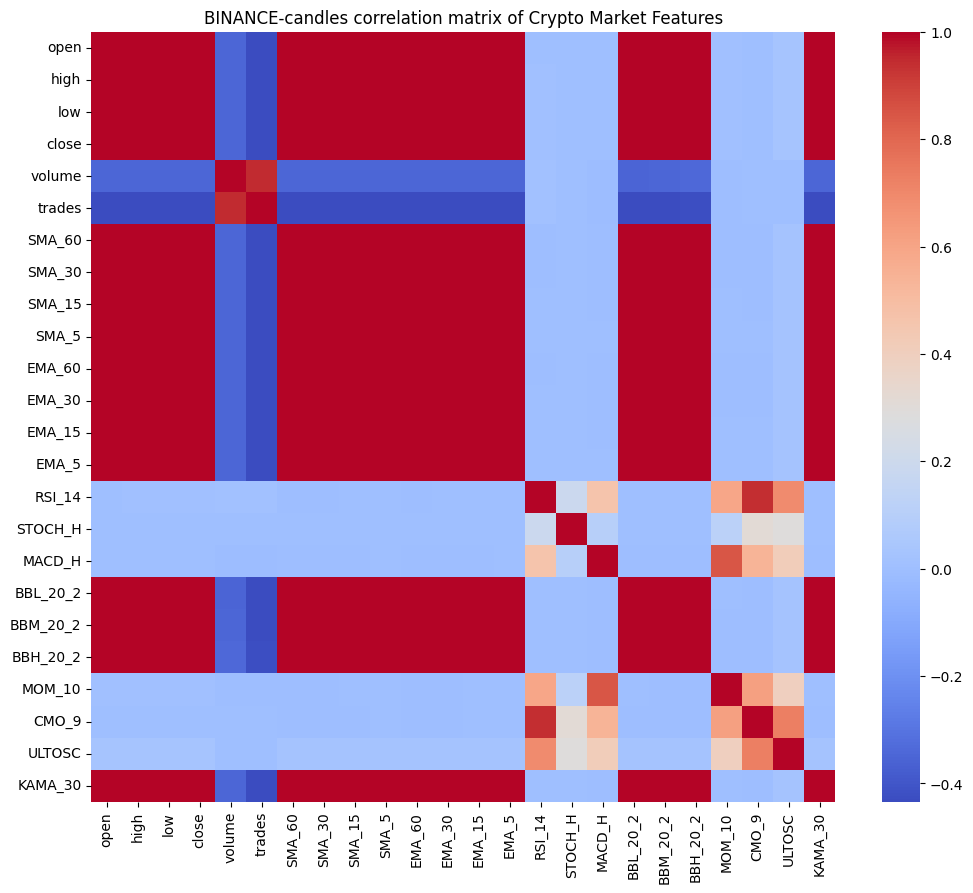

Highly correlated pairs:


,,0
SMA_5,EMA_5,1.000000
EMA_5,SMA_5,1.000000
SMA_15,EMA_15,0.999999
EMA_15,SMA_15,0.999999
SMA_15,BBM_20_2,0.999998
...,...,...
BBL_20_2,BBH_20_2,0.999857
volume,trades,0.947671
trades,volume,0.947671
RSI_14,CMO_9,0.940037


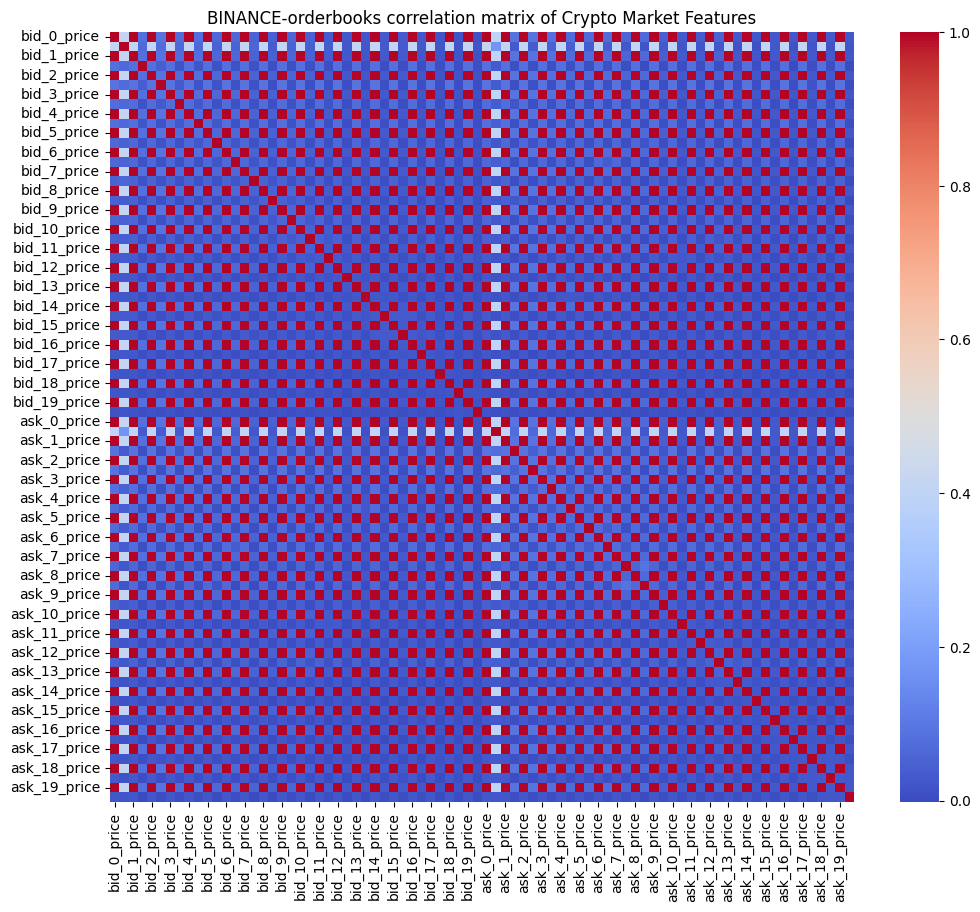

Highly correlated pairs:


,,0
ask_19_price,ask_18_price,1.0
ask_18_price,ask_19_price,1.0
bid_18_price,bid_19_price,1.0
bid_19_price,bid_18_price,1.0
ask_17_price,ask_18_price,1.0
...,...,...
bid_18_price,ask_19_price,1.0
bid_19_price,ask_18_price,1.0
ask_18_price,bid_19_price,1.0
bid_19_price,ask_19_price,1.0


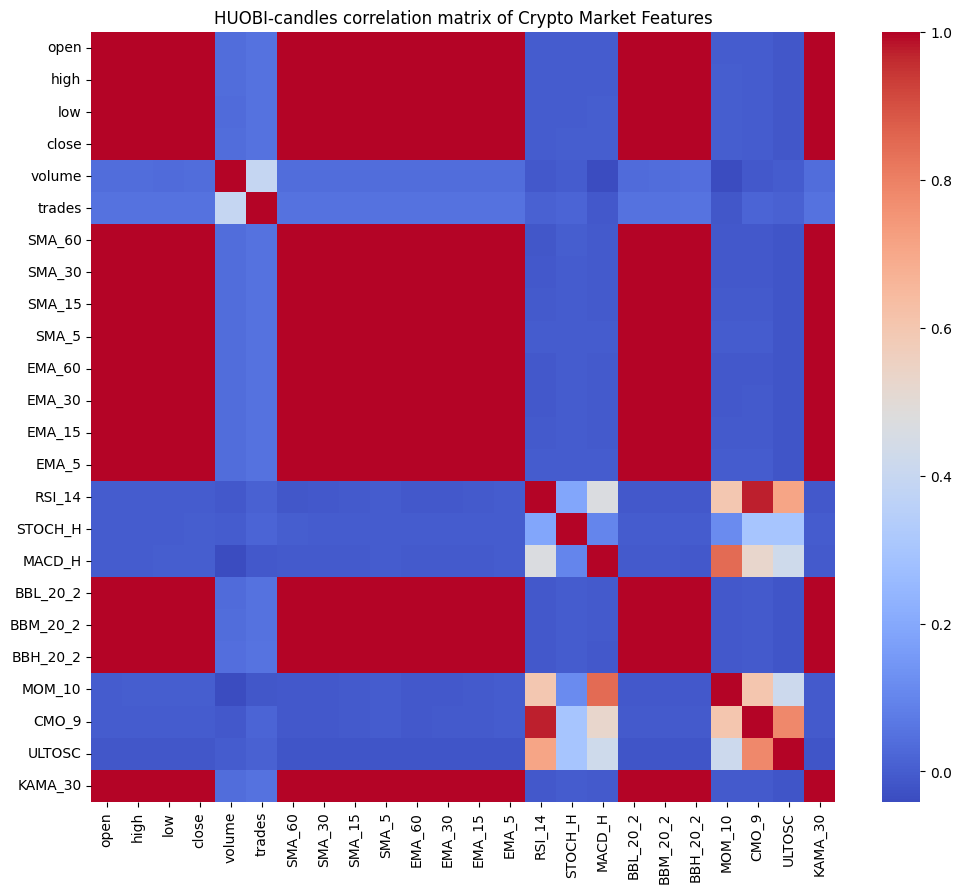

Highly correlated pairs:


,,0
SMA_5,EMA_5,0.999999
EMA_5,SMA_5,0.999999
EMA_15,SMA_15,0.999998
SMA_15,EMA_15,0.999998
BBM_20_2,SMA_15,0.999997
...,...,...
SMA_60,low,0.999837
BBH_20_2,BBL_20_2,0.999758
BBL_20_2,BBH_20_2,0.999758
CMO_9,RSI_14,0.971596


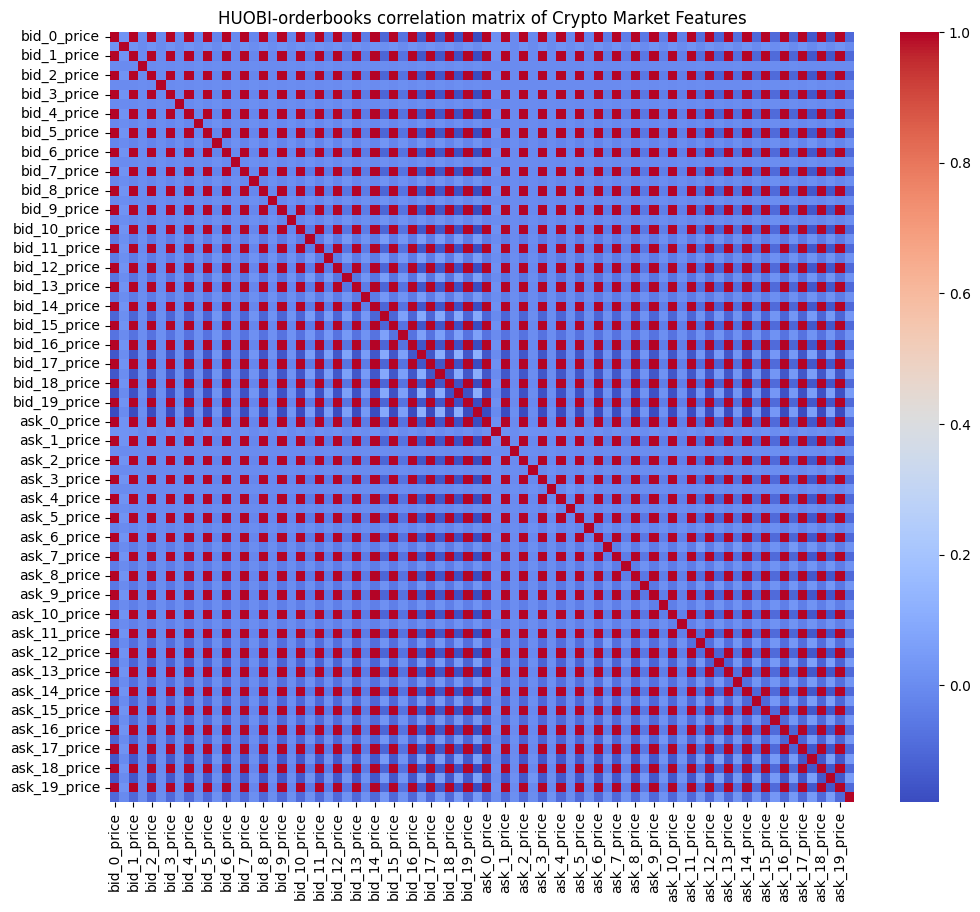

Highly correlated pairs:


,,0
bid_0_price,ask_0_price,1.000000
ask_0_price,bid_0_price,1.000000
ask_18_price,ask_19_price,1.000000
ask_19_price,ask_18_price,1.000000
ask_15_price,ask_16_price,1.000000
...,...,...
ask_19_price,bid_18_price,0.999996
bid_19_price,ask_18_price,0.999996
ask_18_price,bid_19_price,0.999996
ask_19_price,bid_19_price,0.999996


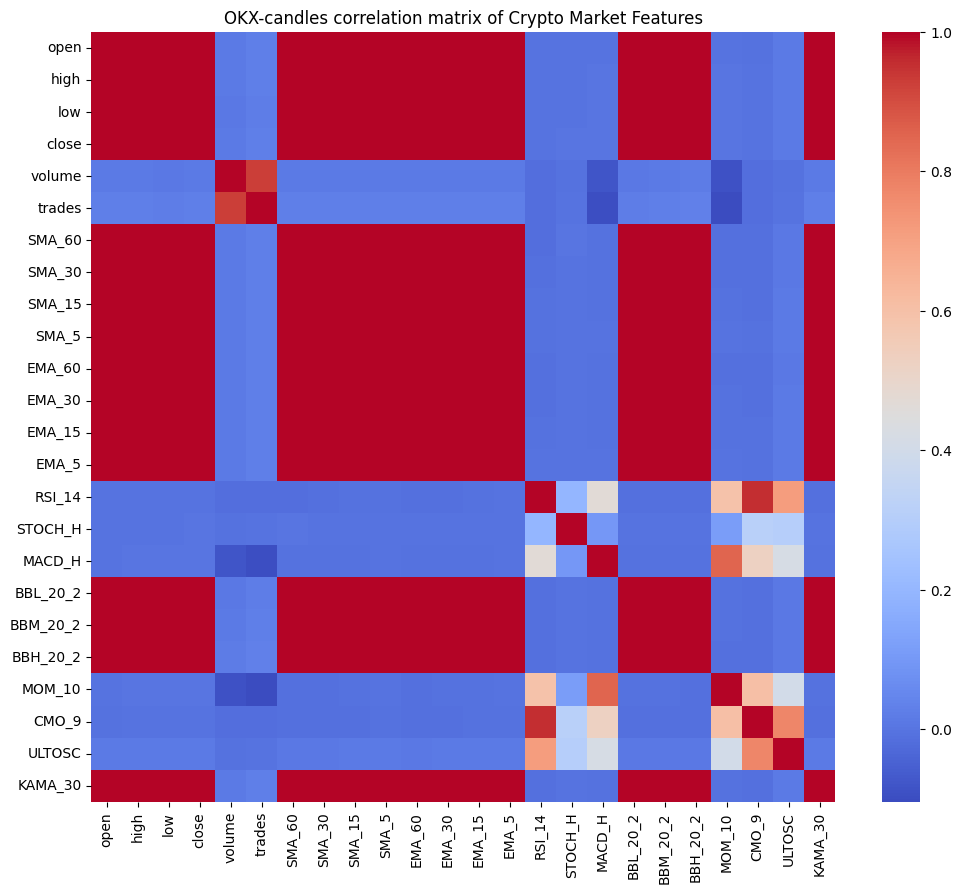

Highly correlated pairs:


,,0
SMA_5,EMA_5,0.999999
EMA_5,SMA_5,0.999999
SMA_15,EMA_15,0.999998
EMA_15,SMA_15,0.999998
BBM_20_2,SMA_15,0.999996
...,...,...
BBL_20_2,BBH_20_2,0.999745
RSI_14,CMO_9,0.954402
CMO_9,RSI_14,0.954402
trades,volume,0.927216


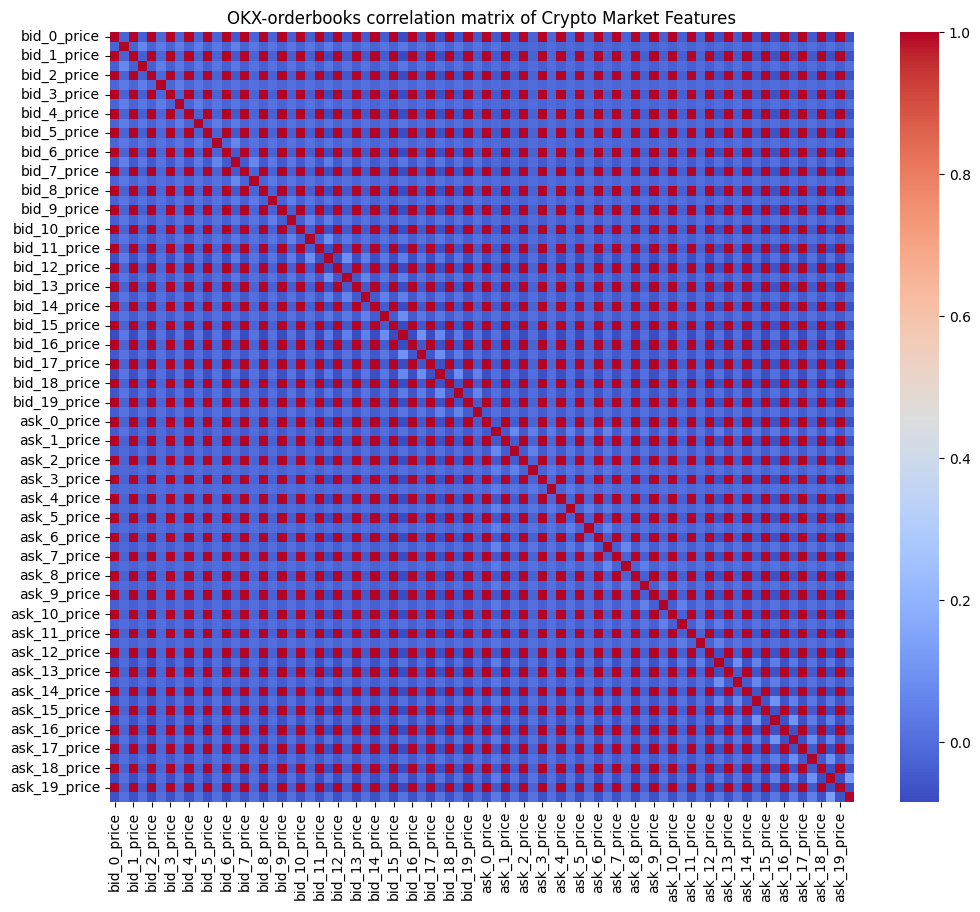

Highly correlated pairs:


,,0
ask_19_price,ask_18_price,1.0
ask_18_price,ask_19_price,1.0
bid_18_price,bid_19_price,1.0
bid_19_price,bid_18_price,1.0
ask_18_price,ask_17_price,1.0
...,...,...
ask_19_price,bid_18_price,1.0
bid_19_price,ask_18_price,1.0
ask_18_price,bid_19_price,1.0
bid_19_price,ask_19_price,1.0


In [13]:
# Correlation matrix

for (data_type, exchange), df in scaled_data.items():
    correlation_matrix = df.corr()
    
    plot_correlation_matrix(data_type, exchange, correlation_matrix)

    highly_correlated_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
    highly_correlated_pairs = highly_correlated_pairs[(highly_correlated_pairs != 1) & (highly_correlated_pairs > CORRELATION_THRESHOLD)]

    print("Highly correlated pairs:")
    display(pd.DataFrame(highly_correlated_pairs))

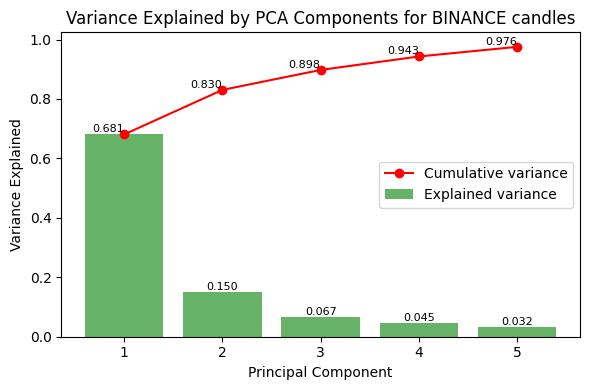

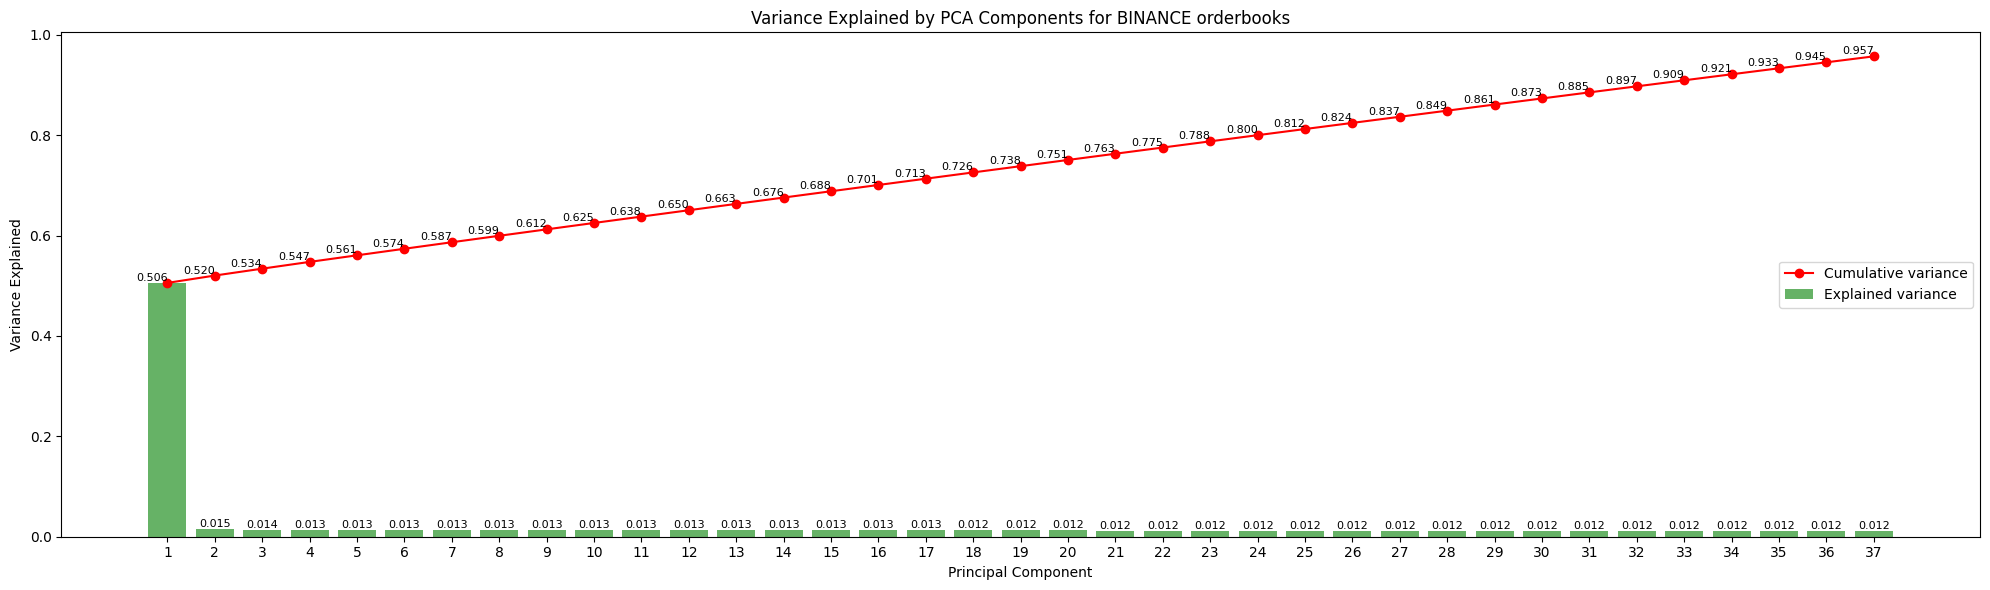

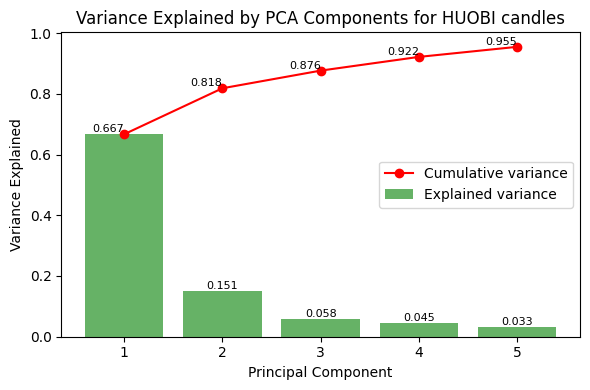

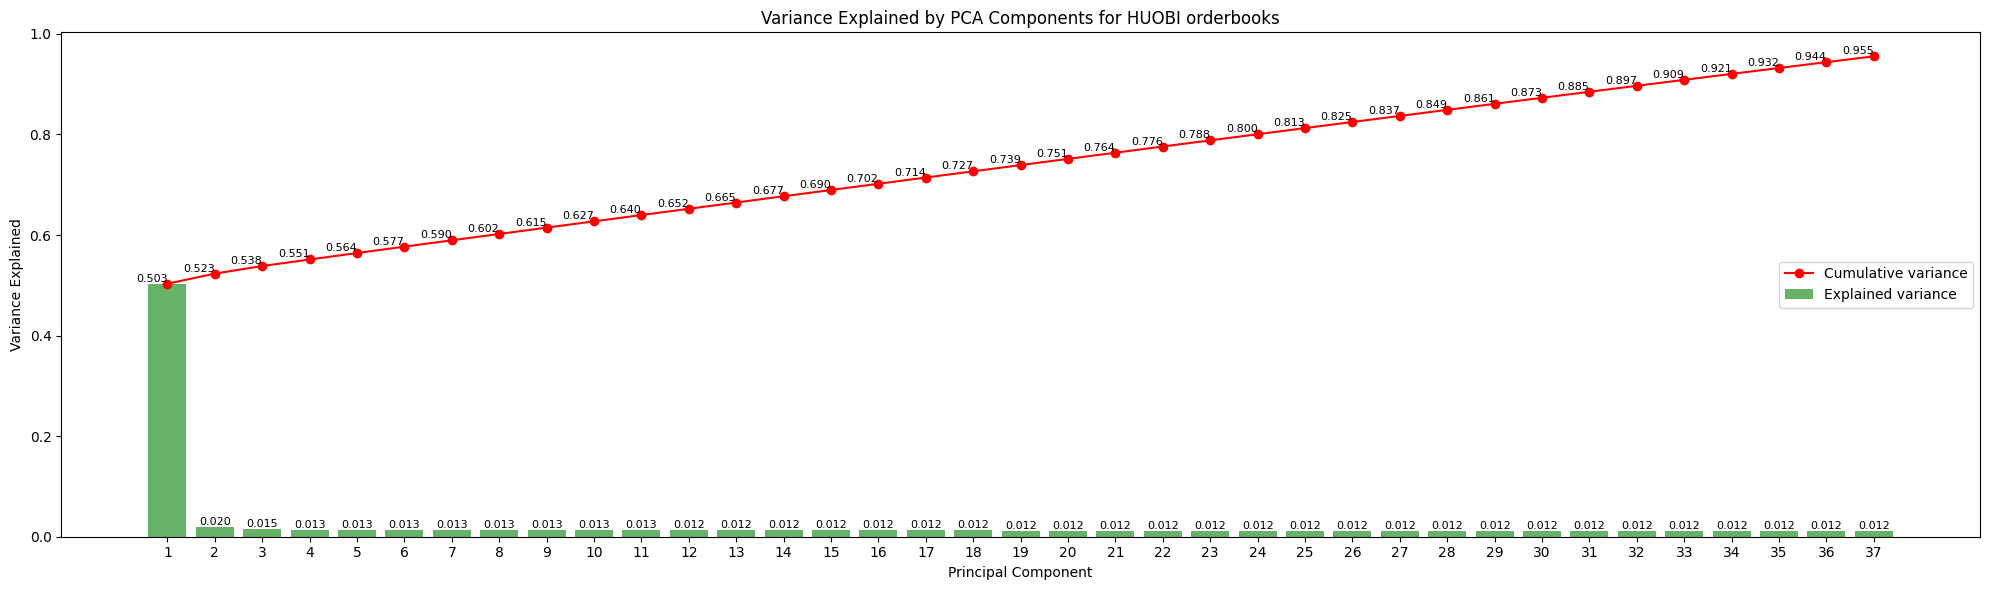

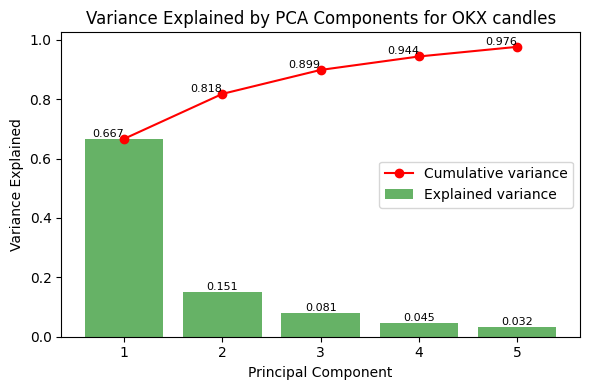

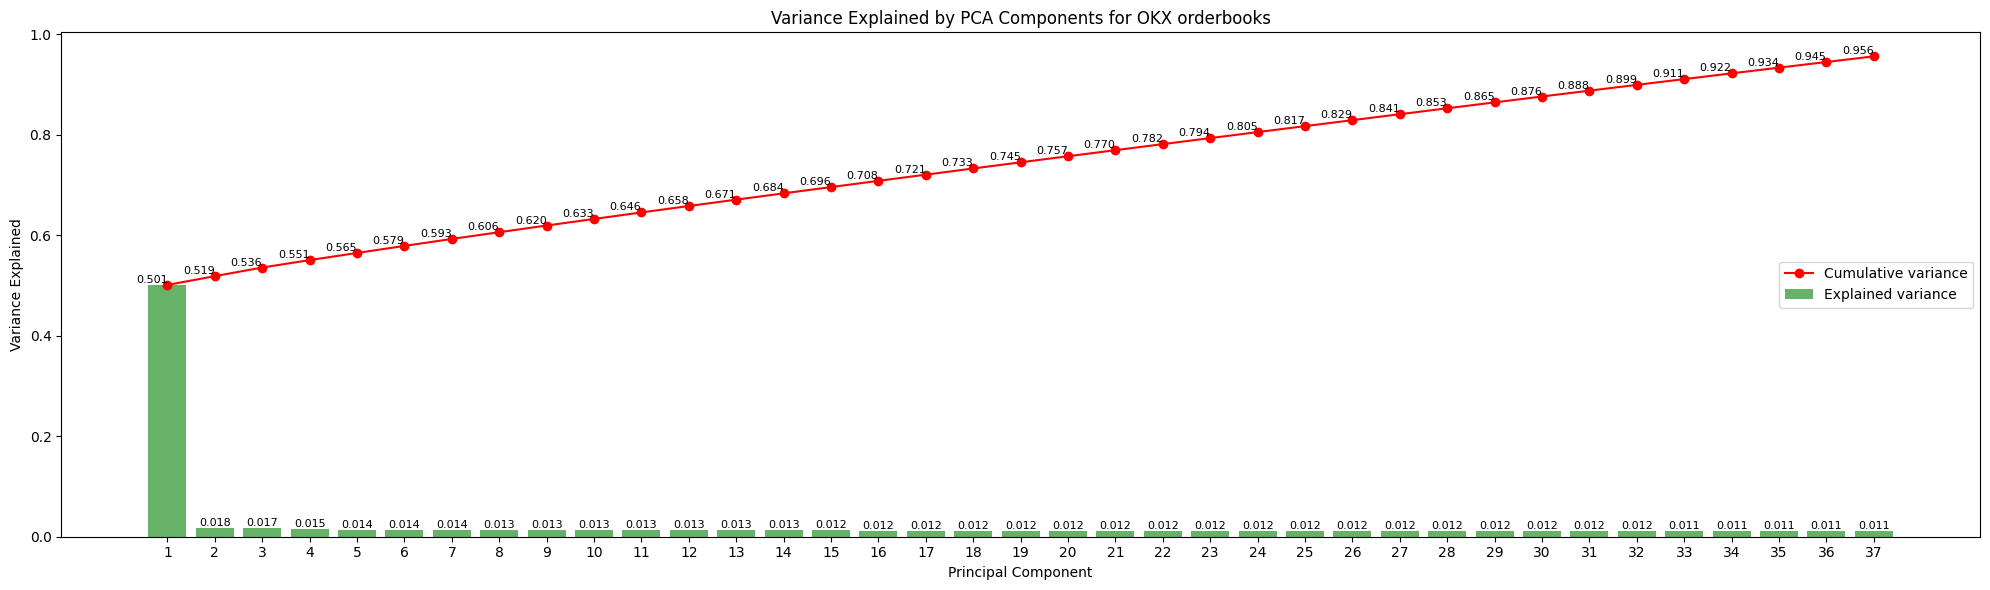

In [14]:
# PCA and explained variance

pca = {}
pca_data = {}

for (data_type, exchange), df in data.items():
    pca[(data_type, exchange)], explained_variance, cumulative_variance = perform_pca(scaled_data[(data_type, exchange)], PCA_VARIANCE_THRESHOLD)
    pca_data[(data_type, exchange)] = {}

    pca_transformed = pca[(data_type, exchange)].transform(scaled_data[(data_type, exchange)])
    pca_transformed_df = pd.DataFrame(pca_transformed)
    pca_transformed_df['origin_time'] = df['origin_time'].values
    pca_data[(data_type, exchange)] = pca_transformed_df

    pd.DataFrame.to_pickle(pca_data[(data_type, exchange)], os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_pca_data.pkl"))

    plot_pca_variance(data_type, exchange, explained_variance, cumulative_variance)

## Candles matrices

These matrices primarily includes various market indicators and technical analysis features such as SMA (Simple Moving Average), EMA (Exponential Moving Average), RSI (Relative Strength Index), MACD (Moving Average Convergence Divergence), etc.
#### There are high correlations among similar indicators
There's a visible high correlation among similar types of indicators, especially among different periods of moving averages (SMA, EMA). This is expected as these indicators are derived from the price and tend to move together.

#### Potential Redundancy
High correlations (close to 1) suggest redundancy among features. For instance, SMA and EMA values that are calculated over similar time frames may provide overlapping information which could be redundant in predictive modeling.

#### Diverse Relationships
Some features show moderate to low correlations, suggesting that they capture different aspects of the market behavior. These features can add valuable diversity to models.

## Orderbooks matrices

These matrices represents features related to the sizes of bids and asks at different levels in an order book. The periodic patterns indicate:

#### Alternating High/Low Correlation
The alternating pattern of high and low correlations suggests a structured dependency in order sizes, possibly alternating between bid and ask sizes or different levels of depth in the order book.

#### Structured Market Dynamics
The structured high correlations (red squares) alternating with lower correlations might indicate typical behaviors in how bids and asks are placed and modified in relation to each other. These patterns might reflect strategic placing/removal of orders at certain levels, influenced by market conditions.

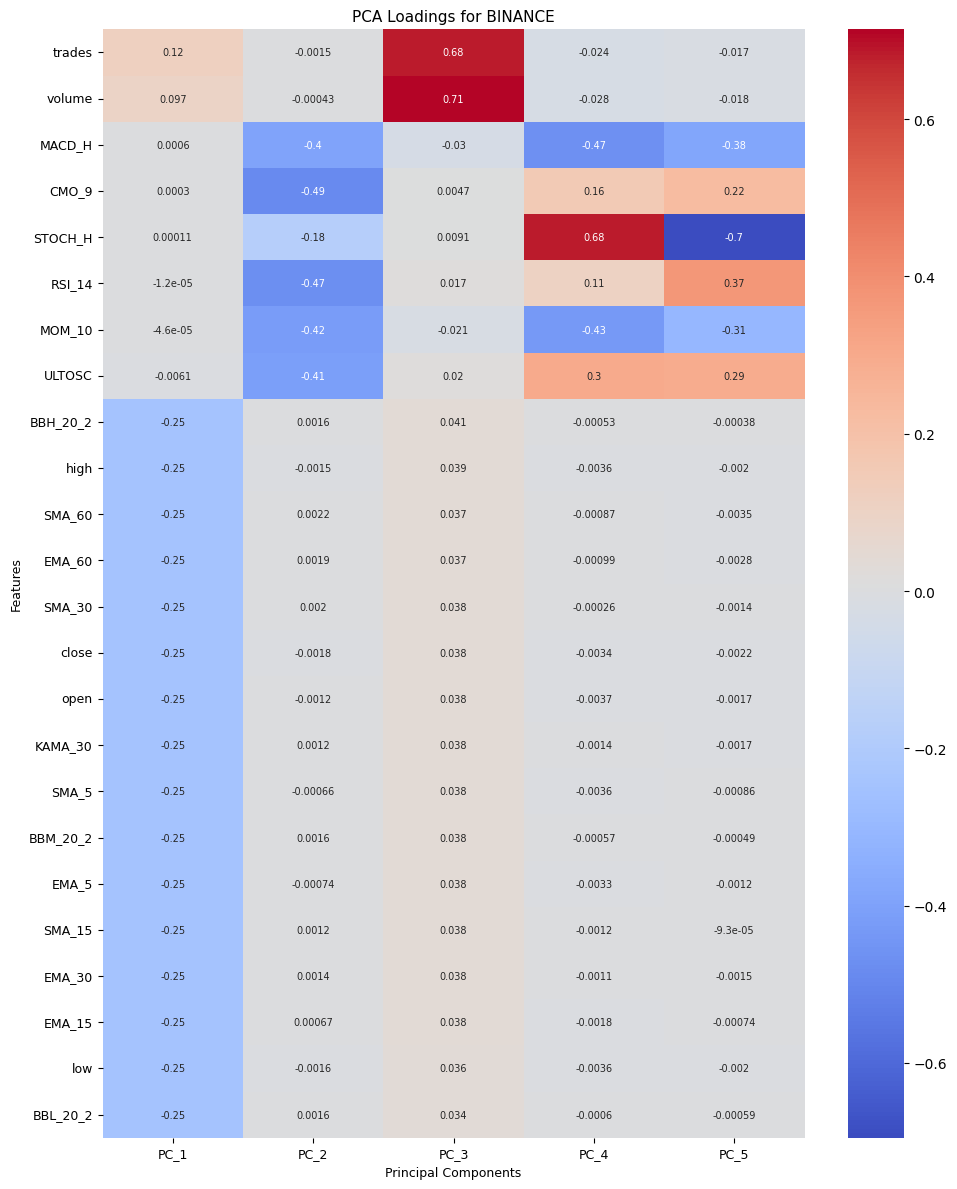

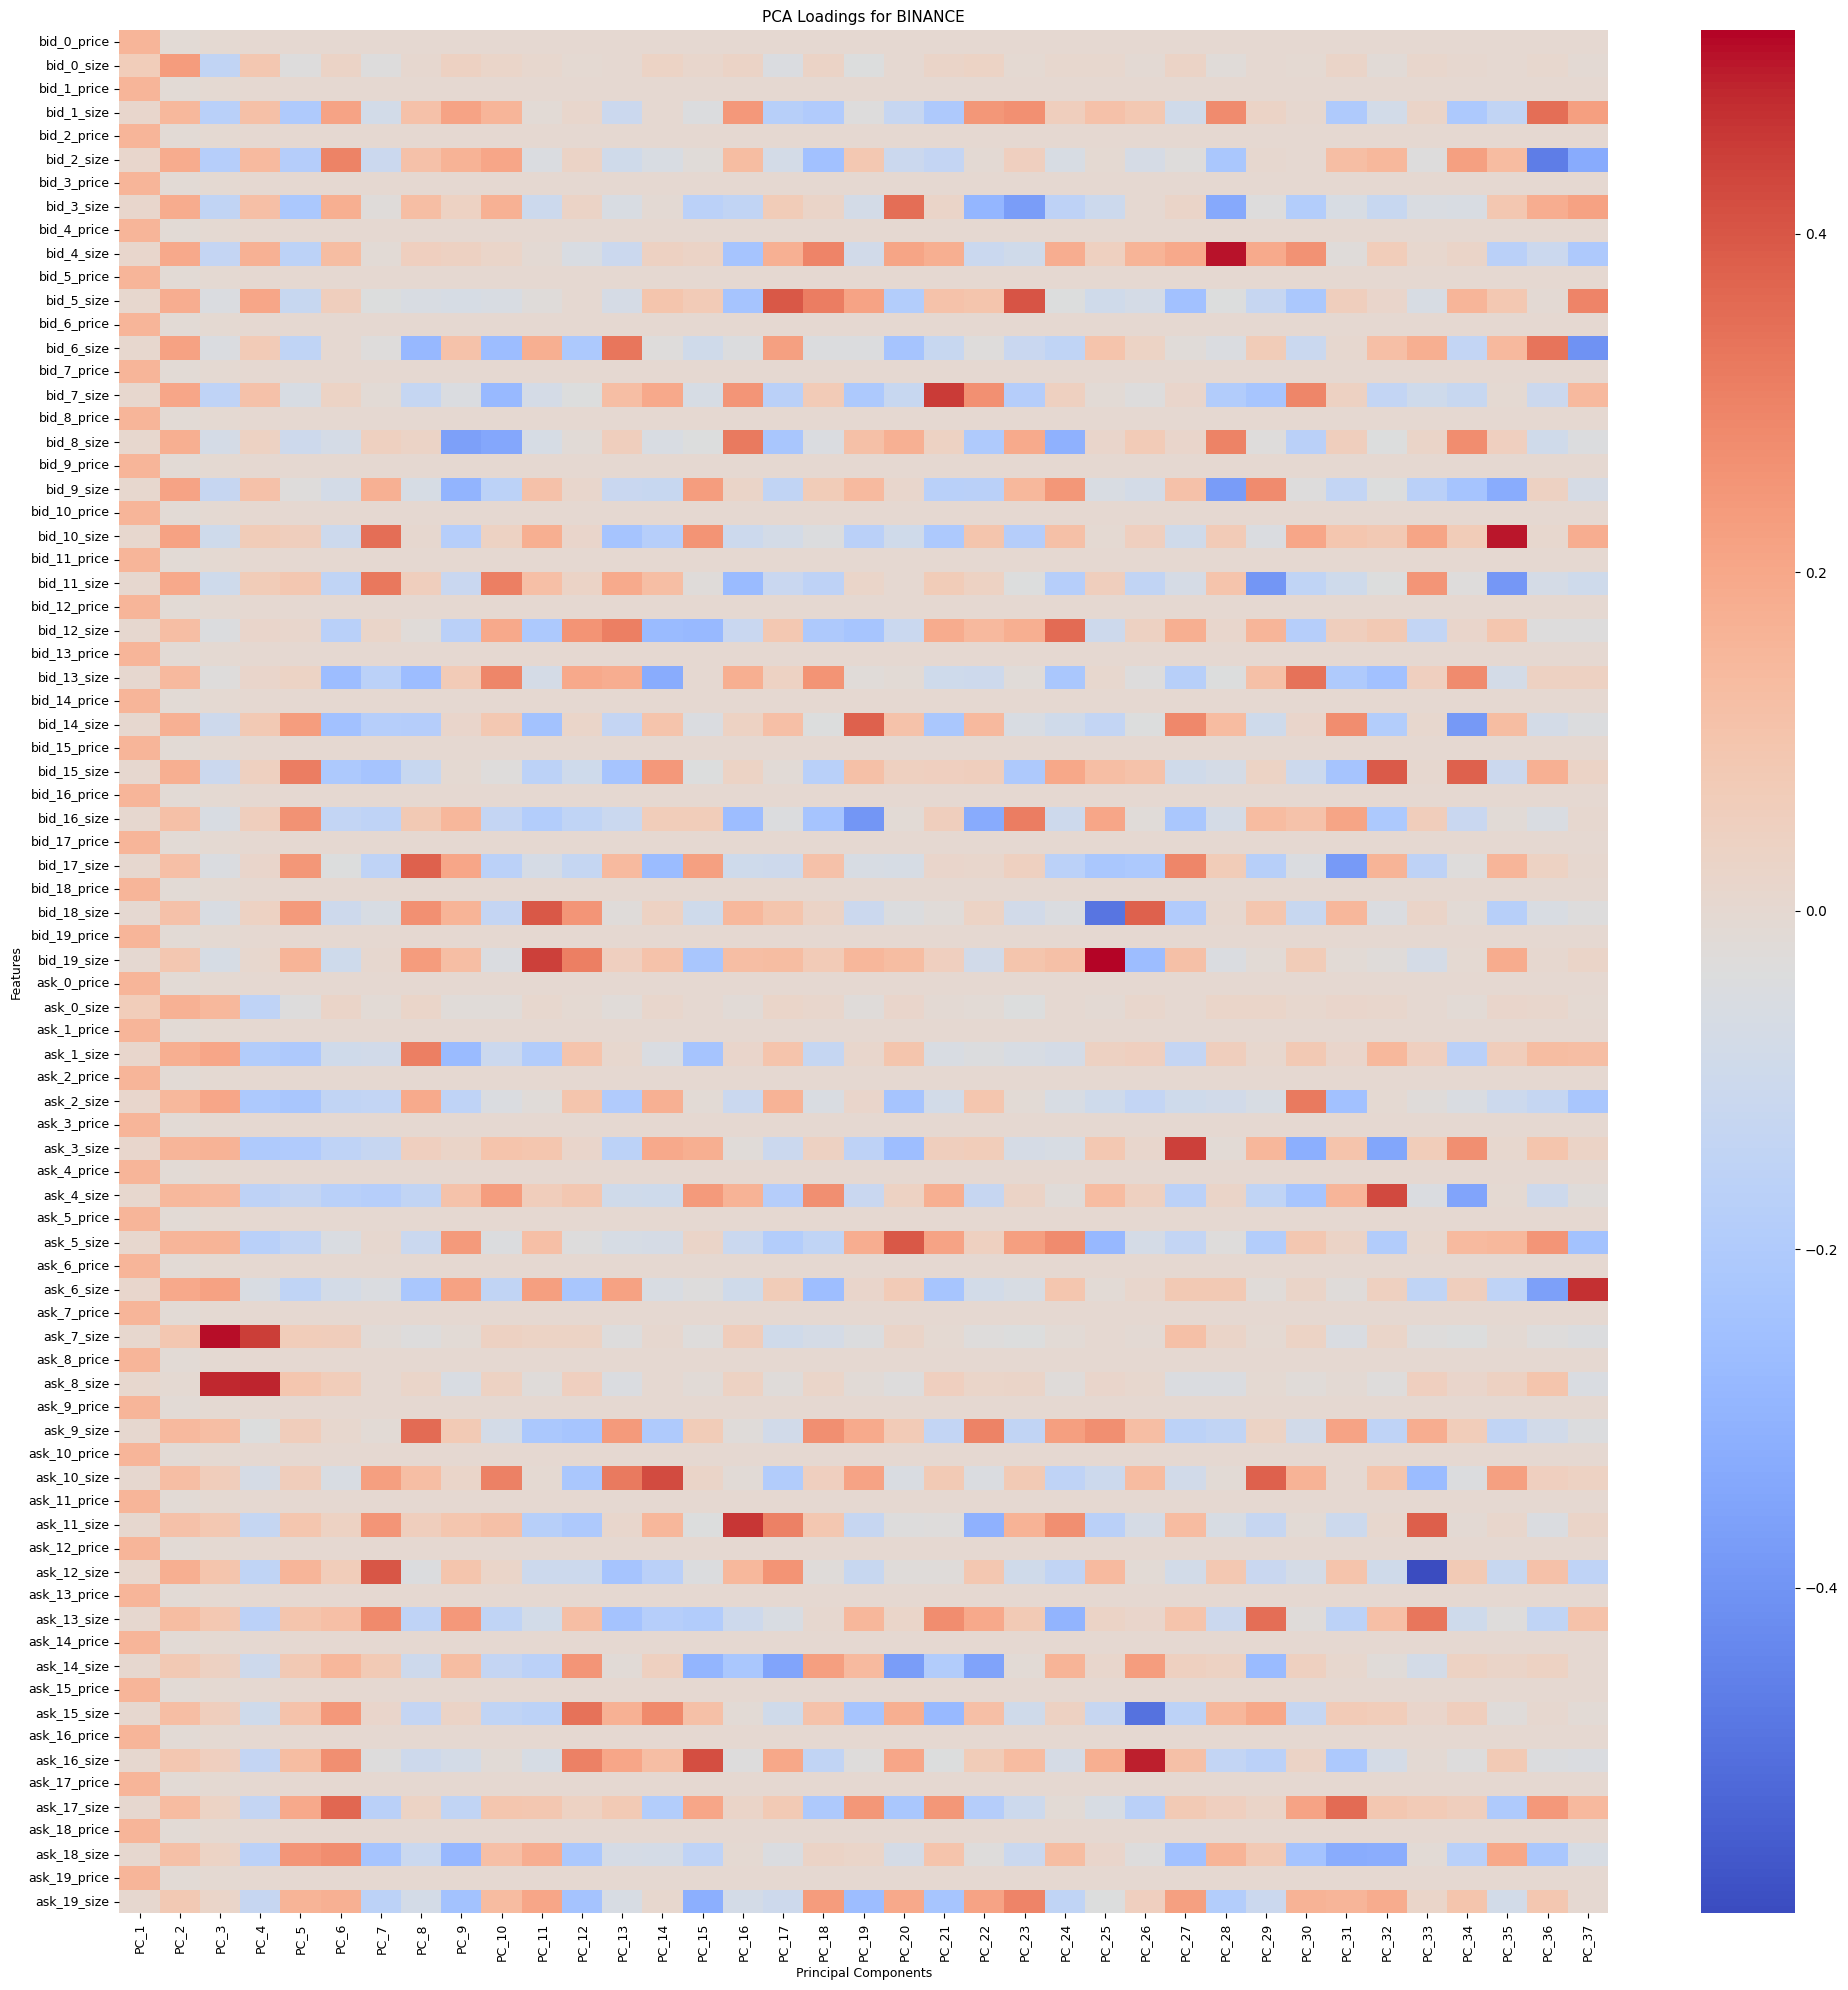

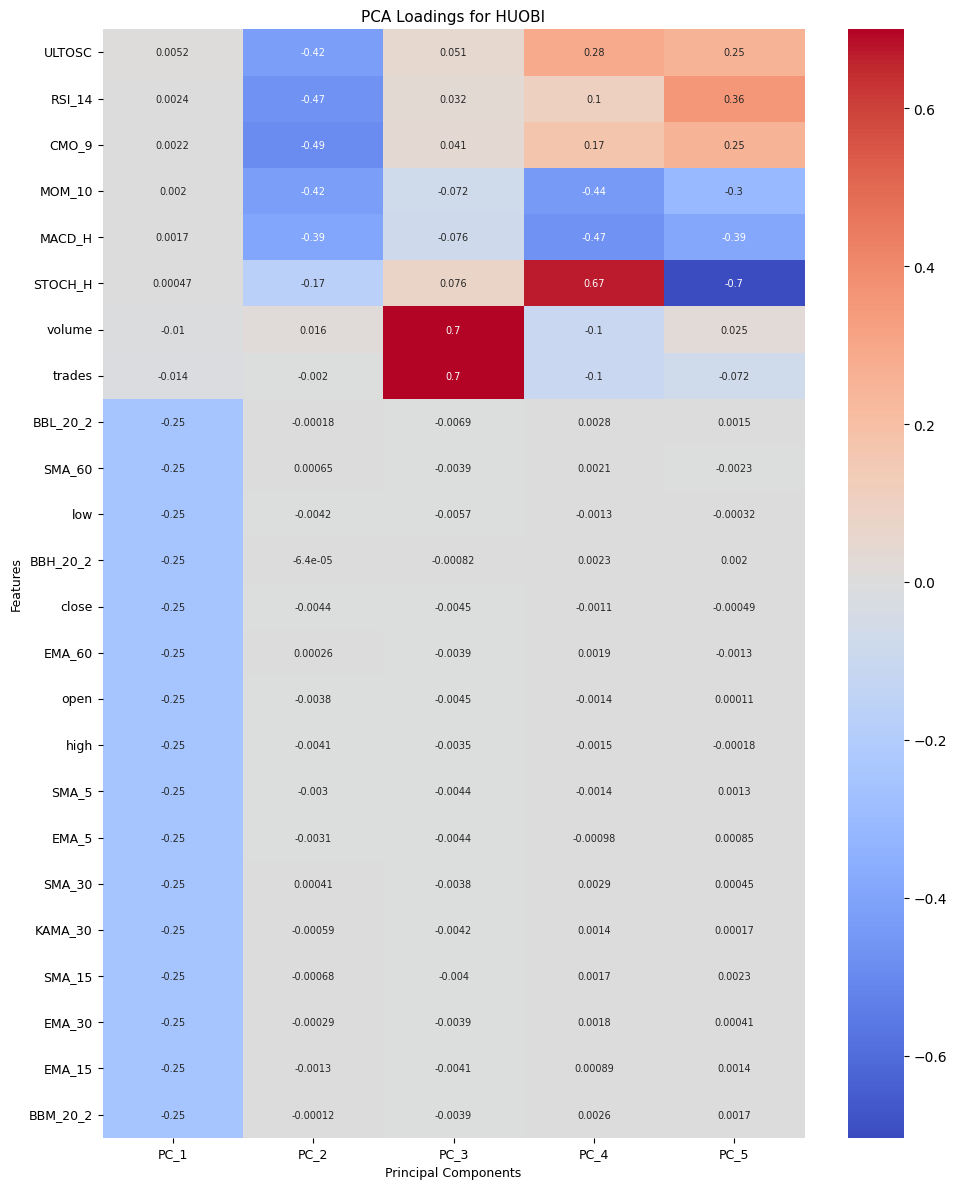

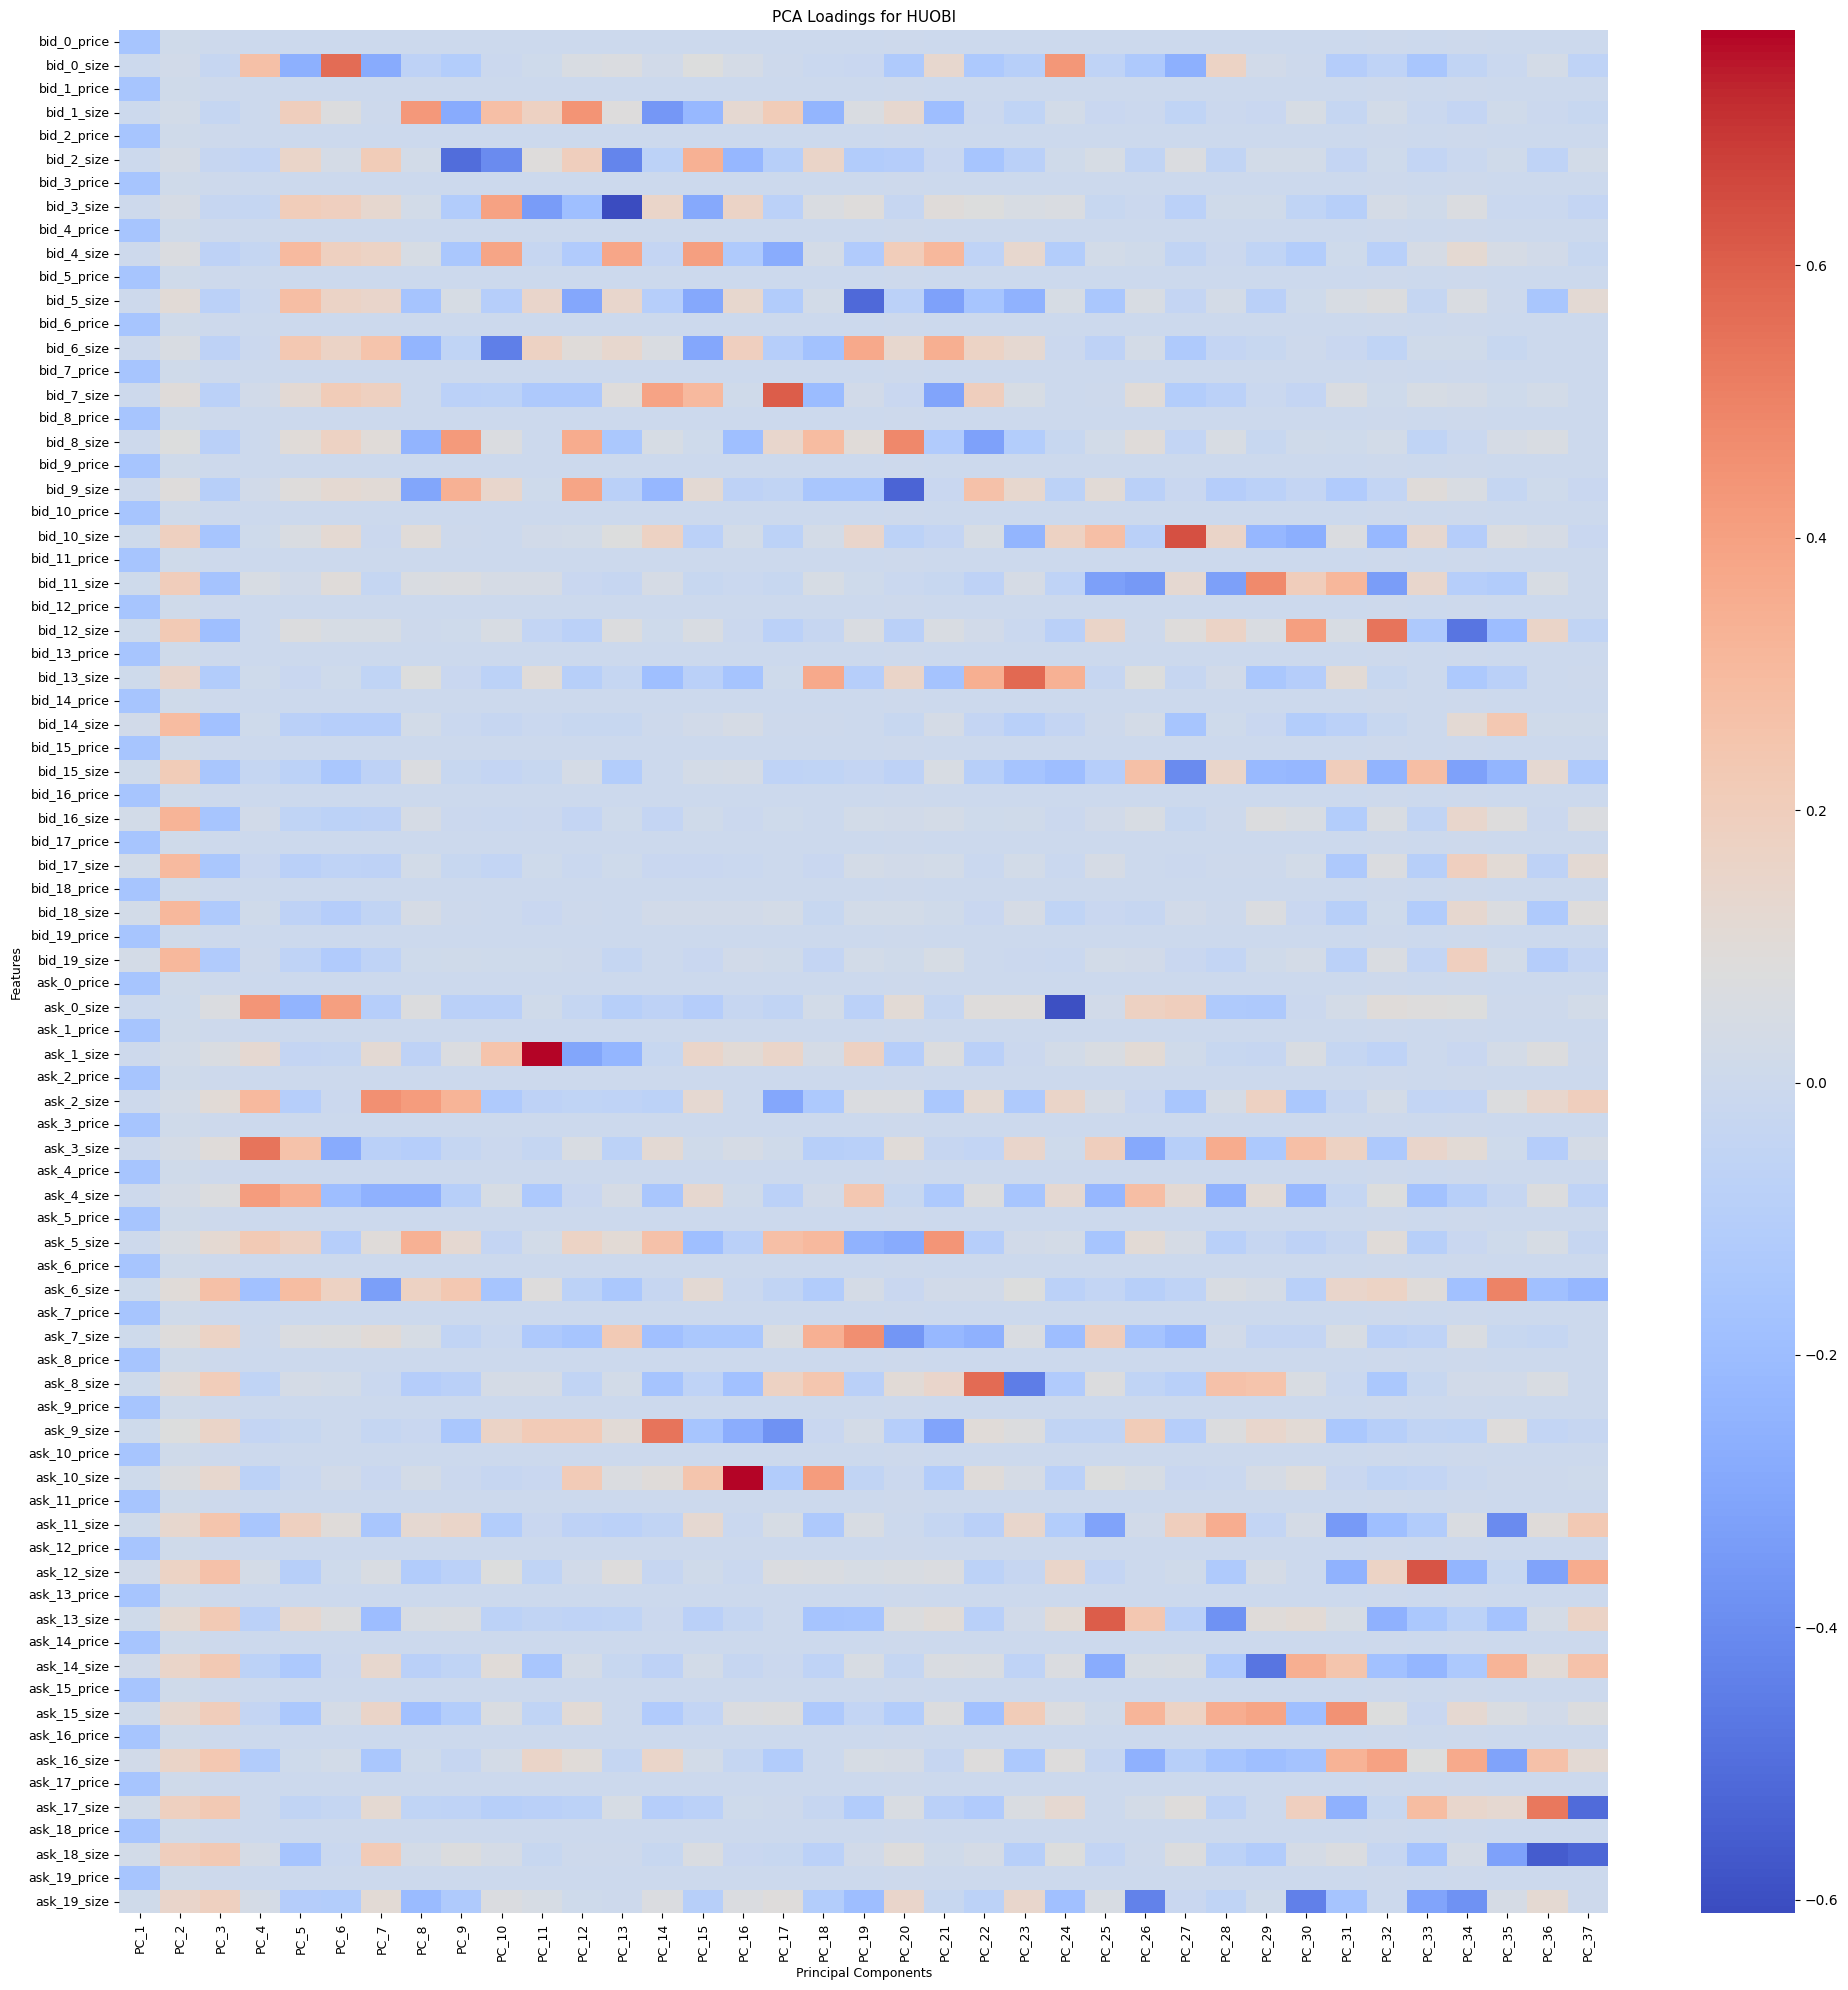

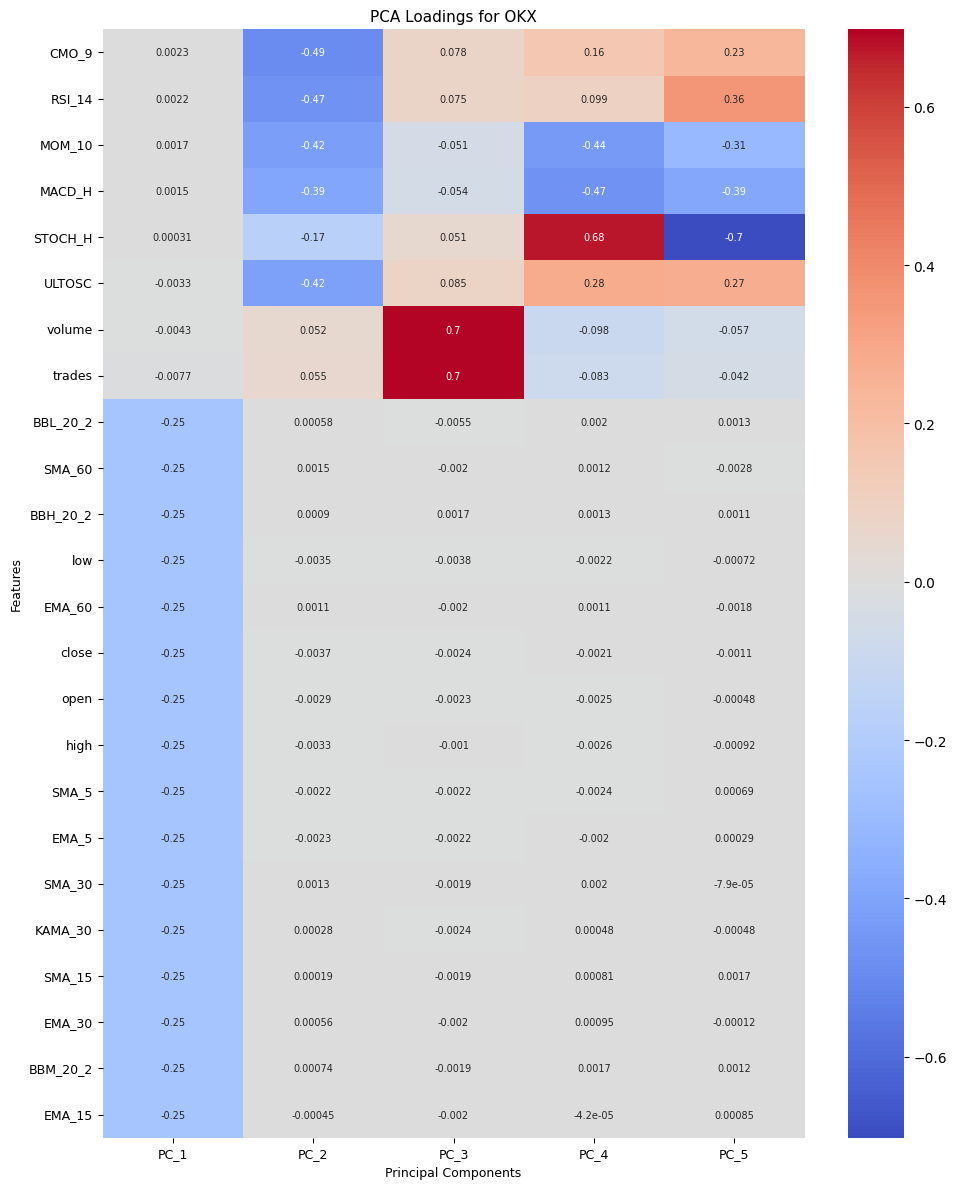

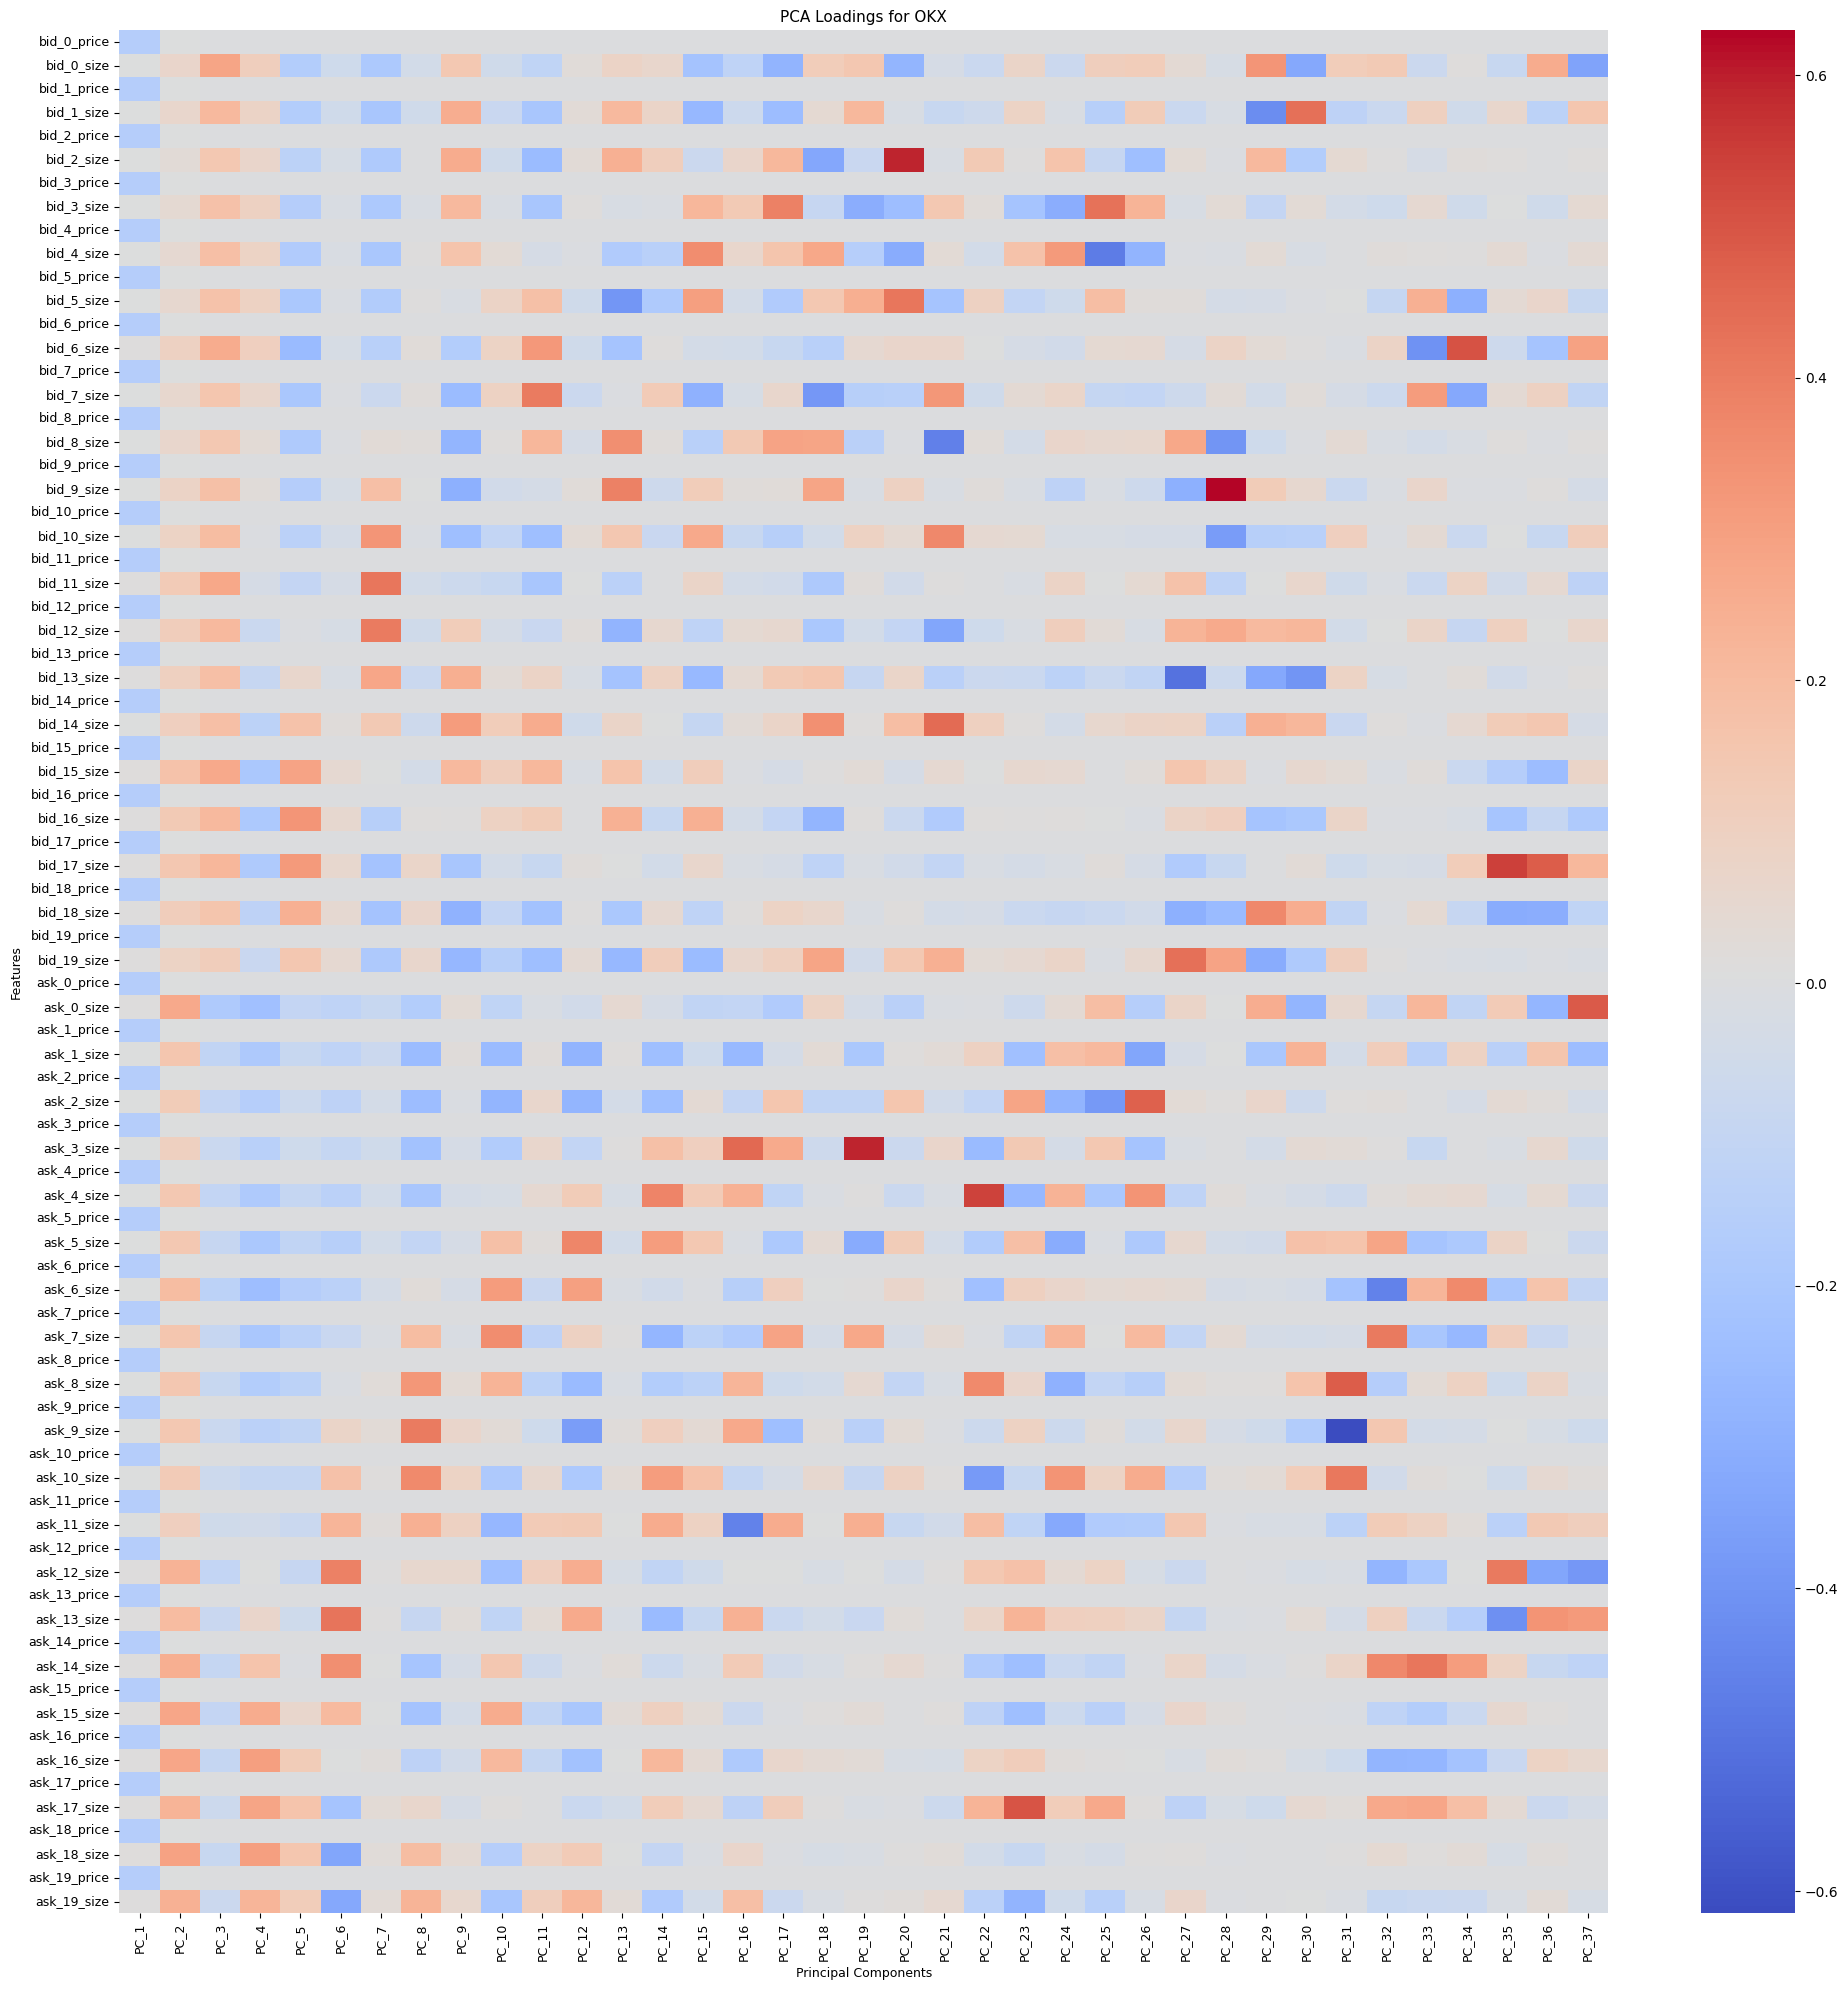

In [15]:
# PCA Loadings: how the original features contribute to the principal components

pca_loadings = {}

for (data_type, exchange), df in scaled_data.items():
    pca_loadings[(data_type, exchange)] = compute_loadings(pca[(data_type, exchange)], scaled_data[(data_type, exchange)])

    pd.DataFrame.to_pickle(pca_loadings[(data_type, exchange)], os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}_pca_loadings.pkl'))
    
    plot_loadings_heatmap(data_type, exchange, pca_loadings[(data_type, exchange)])

In [16]:
ground_truth.head(1)

,origin_time,null,close,next_change,label
0,2022-10-01 00:59:00,False,19402.880859,-0.000661,negative


In [17]:
gt_to_merge = ground_truth.copy()
gt_to_merge = ground_truth[['origin_time', 'label']]
gt_to_merge.head(1)

,origin_time,label
0,2022-10-01 00:59:00,negative


In [18]:
# Merge ground truth with candles and orderbooks
merged_df = {}

for (data_type, exchange), df in data.items():
    merged_df[(data_type, exchange)] = {}
    merged_df[(data_type, exchange)]['full'] = pd.merge(ground_truth[['origin_time', 'label']], df, on='origin_time', how='inner')

    cols_to_drop = ['origin_time', 'label']

    merged_df[(data_type, exchange)]['X'] = merged_df[(data_type, exchange)]['full'].drop(cols_to_drop, axis=1)
    merged_df[(data_type, exchange)]['y'] = merged_df[(data_type, exchange)]['full']['label']

    pd.DataFrame.to_pickle(merged_df[(data_type, exchange)]['full'], os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}_merged.pkl'))

In [19]:
information_gain = {}

for (data_type, exchange), df in merged_df.items():

    # Inner merge ground truth with data on origin_time
    information_gain[(data_type, exchange)] = get_information_gain(df['X'], df['y'])

    pd.DataFrame.to_pickle(information_gain[(data_type, exchange)], os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_information_gain.pkl"))

In [20]:
best_features = {}

for (data_type, exchange), df in pca_loadings.items():
    best_features[(data_type, exchange)] = compare_features_scores(df, information_gain[(data_type, exchange)])
    display(best_features[(data_type, exchange)])

,Loadings_Norm,Information_Gain,Combined_Scores
open,0.000653,0.592997,0.296825
high,0.000865,0.645470,0.323168
low,0.000450,0.610099,0.305274
close,0.000656,0.588491,0.294573
volume,0.636175,0.842278,0.739227
trades,0.597490,1.000000,0.798745
SMA_60,0.000641,0.524248,0.262445
SMA_30,0.000646,0.519069,0.259858
SMA_15,0.000640,0.491506,0.246073
SMA_5,0.000650,0.504896,0.252773


,Loadings_Norm,Information_Gain,Combined_Scores
bid_0_price,2.190751e-07,1.000000,0.500000
bid_0_size,2.025814e-01,0.108689,0.155635
bid_1_price,1.235380e-07,0.961570,0.480785
bid_1_size,9.852319e-01,0.000000,0.492616
bid_2_price,5.403062e-08,0.889084,0.444542
...,...,...,...
ask_17_size,9.919956e-01,0.046425,0.519210
ask_18_price,1.055984e-06,0.817294,0.408647
ask_18_size,9.969399e-01,0.050133,0.523536
ask_19_price,1.025503e-06,0.837137,0.418569


,Loadings_Norm,Information_Gain,Combined_Scores
open,0.000077,0.854330,0.427203
high,0.000061,0.925673,0.462867
low,0.000112,0.910862,0.455487
close,0.000086,0.867663,0.433875
volume,0.619421,0.468566,0.543994
trades,0.621921,0.547182,0.584551
SMA_60,0.000035,0.707210,0.353623
SMA_30,0.000050,0.727729,0.363890
SMA_15,0.000054,0.695689,0.347871
SMA_5,0.000069,0.694965,0.347517


,Loadings_Norm,Information_Gain,Combined_Scores
bid_0_price,0.000051,1.000000,0.500025
bid_0_size,0.996979,0.007465,0.502222
bid_1_price,0.000047,0.887444,0.443745
bid_1_size,0.999553,0.287505,0.643529
bid_2_price,0.000045,0.851861,0.425953
...,...,...,...
ask_17_size,0.994287,0.066960,0.530624
ask_18_price,0.000093,0.835748,0.417920
ask_18_size,0.982642,0.081135,0.531888
ask_19_price,0.000095,0.870683,0.435389


,Loadings_Norm,Information_Gain,Combined_Scores
open,0.000045,0.603750,0.301897
high,0.000042,0.639619,0.319830
low,0.000071,0.658780,0.329426
close,0.000054,0.612922,0.306488
volume,0.618084,0.694469,0.656277
trades,0.615427,1.000000,0.807713
SMA_60,0.000020,0.581639,0.290830
SMA_30,0.000022,0.573085,0.286554
SMA_15,0.000019,0.603268,0.301644
SMA_5,0.000037,0.568679,0.284358


,Loadings_Norm,Information_Gain,Combined_Scores
bid_0_price,1.645577e-06,0.992469,0.496235
bid_0_size,9.880153e-01,0.065713,0.526864
bid_1_price,2.162920e-06,0.974826,0.487414
bid_1_size,9.937239e-01,0.239632,0.616678
bid_2_price,2.312354e-06,0.938908,0.469455
...,...,...,...
ask_17_size,9.294398e-01,0.078982,0.504211
ask_18_price,5.855532e-08,0.876653,0.438326
ask_18_size,6.017699e-01,0.069571,0.335671
ask_19_price,0.000000e+00,0.891844,0.445922


In [21]:
for (data_type, exchange), df in best_features.items():
    print(best_features[(data_type, exchange)].sort_values(by='Combined_Scores', ascending=False))

          Loadings_Norm  Information_Gain  Combined_Scores
trades         0.597490          1.000000         0.798745
volume         0.636175          0.842278         0.739227
MACD_H         0.640573          0.727412         0.683992
MOM_10         0.580784          0.771138         0.675961
STOCH_H        1.000000          0.000000         0.500000
high           0.000865          0.645470         0.323168
KAMA_30        0.000644          0.619459         0.310051
RSI_14         0.483281          0.128807         0.306044
low            0.000450          0.610099         0.305274
open           0.000653          0.592997         0.296825
close          0.000656          0.588491         0.294573
EMA_60         0.000630          0.554323         0.277476
ULTOSC         0.453937          0.089642         0.271790
SMA_60         0.000641          0.524248         0.262445
CMO_9          0.421801          0.098226         0.260013
SMA_30         0.000646          0.519069         0.2598

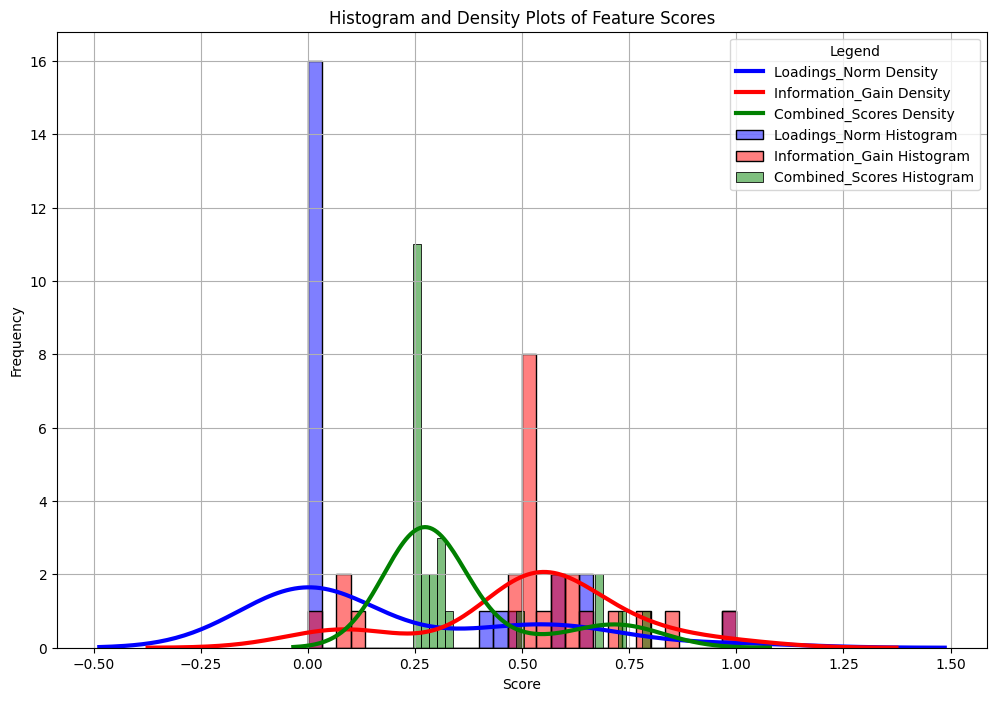

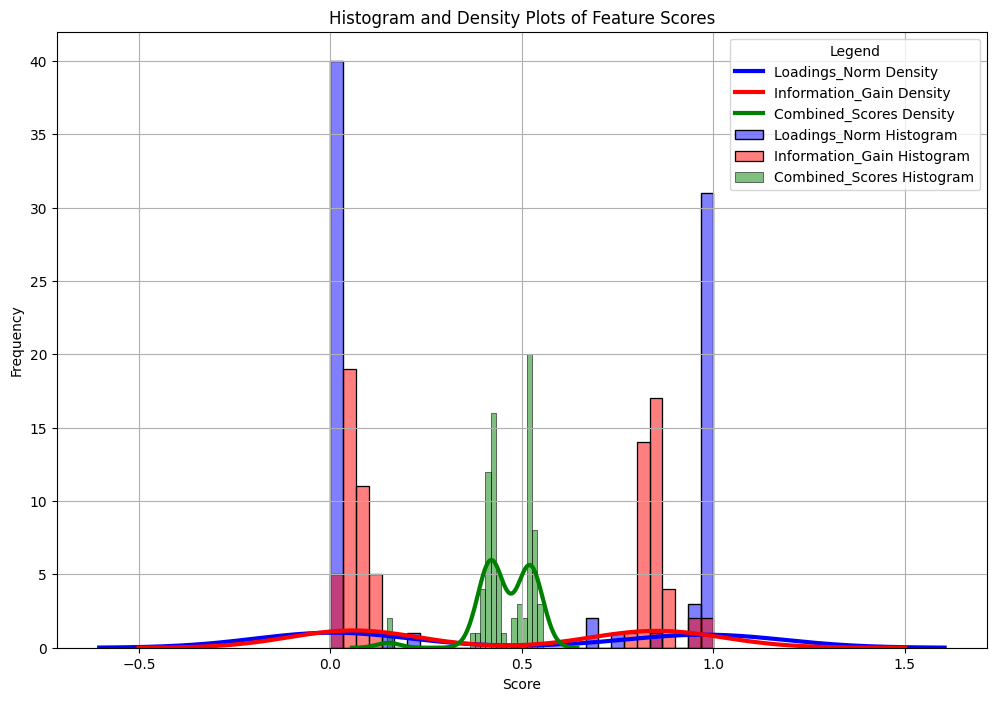

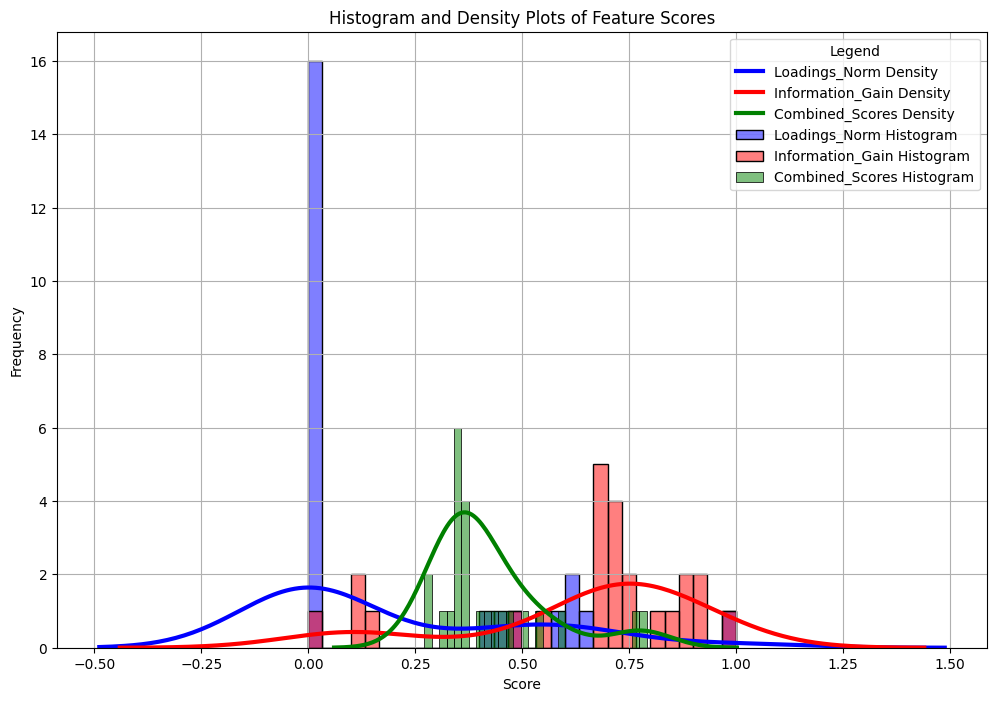

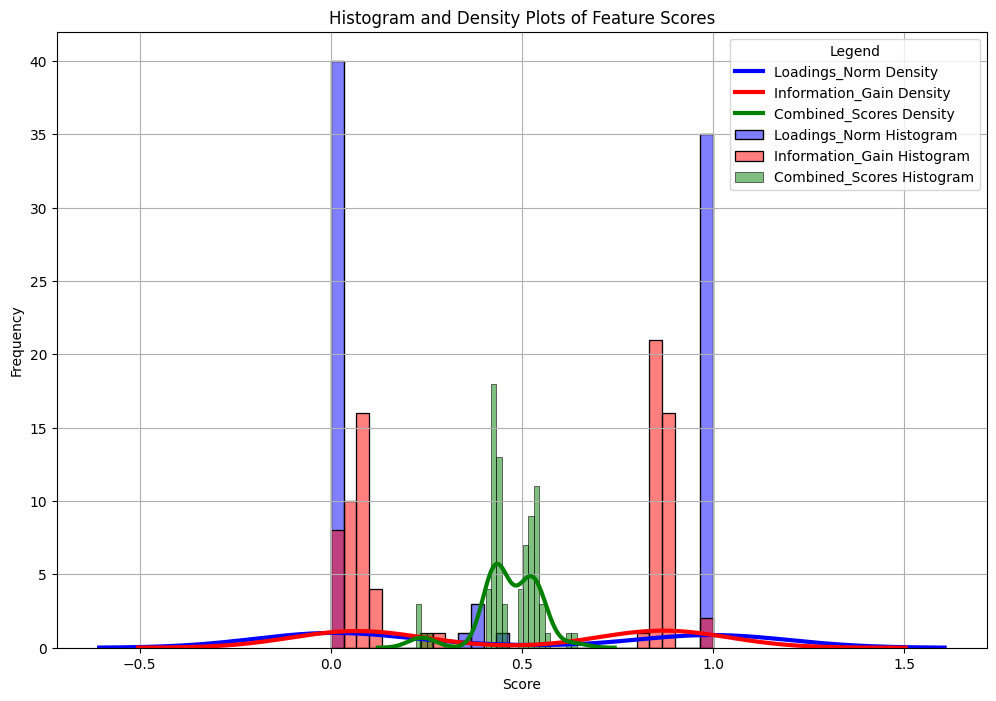

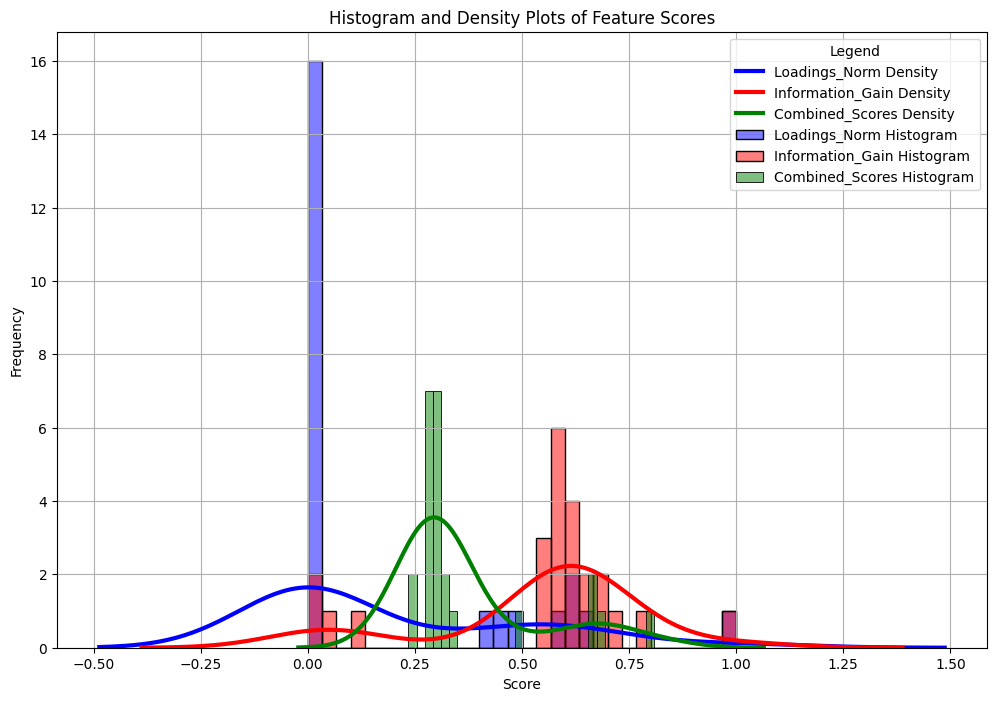

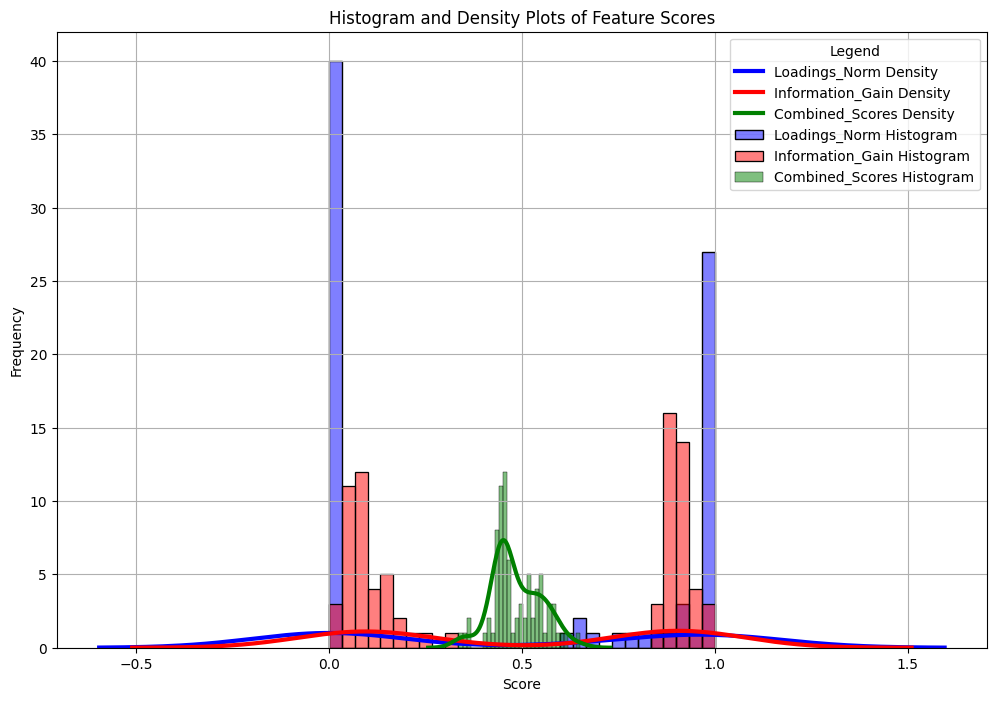

In [22]:
for (data_type, exchange), df in pca_loadings.items():
    plot_histogram_density(data_type, exchange, best_features[(data_type, exchange)], ['Loadings_Norm', 'Information_Gain', 'Combined_Scores'], ['blue', 'red', 'green'])

In [23]:
for (data_type, exchange), df in best_features.items():
    percentile_90 = np.percentile(df['Combined_Scores'], 80)

    # Select features with scores above this percentile
    selected_features = df[df['Combined_Scores'] >= percentile_90]

    # Count the number of selected features
    num_selected_features = selected_features.shape[0]
    print(f"{exchange}-{data_type} - Number of selected features: {num_selected_features}")

BINANCE-candles - Number of selected features: 5
BINANCE-orderbooks - Number of selected features: 16
HUOBI-candles - Number of selected features: 5
HUOBI-orderbooks - Number of selected features: 16
OKX-candles - Number of selected features: 5
OKX-orderbooks - Number of selected features: 16
